# 创建数据集
首先，我们的知识图模型在选择的12个文档上进行了训练。这些文档是根据整个数据集前两个任务的BERT结果获取的。这些文件的标题列表是：
1. 孕妇感染 COVID-19 有哪些风险？(What are the risks of COVID-19 infection in pregnant women?)
2. 胃肠病学家和患者应该了解哪些关于 COVID-19 的知识？(What Should Gastroenterologists and Patients Know About COVID-19?)
3. 高绩效的卫生系统能否抵御 COVID-19 流行病？(Are high-performing health systems resilient against the COVID-19 epidemic?)
4. 登革热病毒糖基化：我们知道什么？(Dengue Virus Glycosylation: What Do We Know?)
5. 蝙蝠可以作为虫媒病毒的储存库吗？(Can Bats Serve as Reservoirs for Arboviruses?)
6. 关于病毒的进化和出现，我们可以预测什么？(What can we predict about viral evolution and emergence?)
7. 病原体基因组序列何时能提供传播事件的信息？(When are pathogen genome sequences informative of transmission events?)
8. 遗传多样性是否会限制疾病在自然宿主种群中的传播？(Does genetic diversity limit disease spread in natural host populations?)
9. 汉坦病毒进化的时间尺度是多少？(What is the time-scale of hantavirus evolution?)
10. 基于主机的早期预警对疾病暴发的影响。(The Impact of Host-Based Early Warning on Disease Outbreaks.)
11. 特应性会影响病毒性肺炎的病程吗？(Does atopy affect the course of viral pneumonia?)
12. MHC 多样性降低会降低脊椎动物种群的生存能力吗？(Does reduced MHC diversity decrease viability of vertebrate populations?)

在此之后作为第二步，我们在来自`biorxiv_medrxiv`数据集的1000 多个文档上训练我们的模型。

我们从模型中导出结果的查询列表是：
1. 对传播、孵化和环境稳定性了解多少？(What is known about transmission, incubation,and environmental stability?)
2. 我们对 COVID-19 风险因素了解多少？(What do we know about COVID-19 risk factors? )
3. 我们对病毒的遗传学、起源和进化了解多少？(What do we know about virus genetics, origin, and evolution?)
4. 我们对疫苗和疗法了解多少？(What do we know about vaccines and therapeutics?)
5. 发表了哪些关于医疗保健的文章？(What has been published about medical care?)
6. 我们对非药物干预了解多少？(What do we know about non-pharmaceutical interventions?)
7. 我们对诊断和监测了解多少？(What do we know about diagnostics and surveillance?)
8. 发表了哪些关于伦理和社会科学方面的考虑？(What has been published about ethical and social science considerations?)
9. 关于信息共享和跨部门合作，发表了哪些内容？(What has been published about information sharing and inter-sectoral collaboration?)
10. COVID-19 的死亡率是否存在地域差异？(Are there geographic variations in the mortality rate of COVID-19?)



前两个结果使用我们对12个文档采用的初始方法，后面的结果包括使用 biorxiv_medrxiv 数据集的最新工作的结果.

我们还提出了另外两个问题，并尝试仅针对第2节（BERT 训练和文档提取）中解释的 BERT 提取结果

在提取文档的第一步中，我们在所有45k标题上运行了 BERT 嵌入。 请找到少数 TASK 的结果，这只是为了检查 BERT 的有效性。

有大量数据可用，研究人员很难在每次出现查询时浏览每篇论文。
这种方法旨在使研究人员和科学家更容易完成这项任务。
每次出现查询时，规定的模型将返回相关论文的列表，其中包含可以找到这些查询的相关答案的段落。


该模型使用知识图谱与本体和Bert嵌入的组合。
启用图形的搜索可帮助用户根据非常具体的医学术语进行搜索。
它还可以扩展以推断不同文档如何相互关联（基于作者、正文、标题等）

＃# 两个研究内容
1.给定一个自然语言查询，从语料库中返回具有语义相似含义的相关文档。
2.给定一个自然语言查询，将具有相关关键短语的相关段落返回给查询。

## 从 JSON 文档中提取实体：

从每个JSON文档的标题、作者详细信息、摘要、正文和参考书目中提取实体。然后使用这些实体来制作三元组以创建知识图谱。三元组中包含5种关系。实体通过以下关系映射到它们各自的论文 ID：
* has_author：直接提取作者的名字和姓氏。
* Has_title：名词和代词是使用 Spacy 从标题中提取的，我们还添加了 DBPedia 和 Scispacy 模型。
* Has_abstract：名词和代词是从摘要中提取的。此外，使用了从 spacy 中提取实体的预定义函数，并将这两者的并集与 DBpedia 和 Scispacy 模型一起使用
* Has_body：使用主题排名算法提取关键短语。对于没有足够候选关键短语提取的文本，实体的提取方式与摘要相同，同时采用 DBPedia 和 Scipacy 模型。
* Has_reference：该关系的实体以与抽象相同的方式提取，以及 DBPedia 和 Scispacy 模型。


提取的所有实体，使用最常见的词库进一步过滤，以去除频繁出现的词，只保留稀有词。这使我们的模型更加特定于医学领域。


### 提取文献实体

对于三元组中的每个实体，从本体中提取前5个对应的相似实体。
这些实体也包含在三元组中，以及它们的对应关系，使知识图谱不仅涵盖文档中存在的术语，还涵盖不存在但可能有用的相关实体。

In [ ]:
filelist=[]

import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        filelist.append(os.path.join(dirname, filename))

import json
import pke
import numpy as np
import time
import pandas as pd
import spacy
import re
import string
import en_core_web_sm
import requests
import en_ner_bionlp13cg_md
import scispacy
import time

nlpp = en_ner_bionlp13cg_md.load()
max_dbp_size = 70000

def splitting(text):
    words = text.split()
    subs = []
    n = 50
    for i in range(0, len(words), n):
        subs.append(" ".join(words[i:i+n]))
    return subs


def get_spacy_entities(document):
    """
    显示单词实体
    返回：图像渲染和命名、未命名词实体列表和实体标签
    """

    doc = nlpp(document)
    entity = [X.text for X in doc.ents]
    return entity


class APIError(Exception):
    def __init__(self, status):
        self.status = status
    def __str__(self):
        return "APIError: status={}".format(self.status)


def annotate_text(text):
    # base_url = "http://api.dbpedia-spotlight.org/en/annotate"
    base_url = "Add your DBPedia Server URL"
    params = {"text": """{}""".format(text),
              "confidence": 0.35}
    headers = {'accept': 'application/json'}
    res = requests.get(base_url, params=params, headers=headers)
    if res.status_code != 200:
        raise APIError(res.status_code)
    data = json.loads(res.text)
    return data


def dbp(text):
    data = annotate_text(text)
    entities=[]
    if ("Resources" in data):
        resources = data["Resources"]
        entities = list()
        for each in resources:
            entity = each["@surfaceForm"]
            if entity not in entities:
                entities.append(entity)
    return entities


triples=[]
nlp = en_core_web_sm.load()
w="words.txt"
file = open(w,"r")
f = file.readlines()
word = []
for w in f:
    word.append(w.replace("\n", ""))


for item1 in filelist:
        with open(item1,"r") as object:
                data = object.read()
        obj = json.loads(data)
        paperid = obj['paper_id']
        title = obj['metadata']['title']
        authors = obj['metadata']['authors']
        abstract = obj['abstract']
        bib = obj['bib_entries']
        body = obj['body_text']
        triples1=[]
        titledb = dbp(title)
        for item in titledb:
            l=[item, paperid, 'has_title', 'DBPedia']
            triples.append(l)
        titlesp = get_spacy_entities(title)
        for item in titlesp:
            l=[item, paperid, 'has_title', 'SciSpacy']
            triples.append(l)
        title = nlp(title)
        for token in title:
                if((token.pos_ == "PROPN") or (token.pos_ == "NOUN")):
                        if(len(token.text) > 2):
                                triples1.append(token.text)
        triples1 = list(set(triples1) - set(word))
        for item in triples1:
                l=[item, paperid, 'has_title']
                triples.append(l)
        for item in authors:
                name = item['first'] + " " +  item['last']
                l = [name, paperid, 'has_author']
                triples.append(l)
        abss=""
        for item in abstract:
                abss = abss + item['text'] + " "
                abss = abss + a1 + " "
                if len(a1) >= max_dbp_size:
                    x_list = splitting(a1)
                else:
                    x_list = [a1]
                for x_small in x_list:
                    abssd = dbp(x_small)
                    for item in abssd:
                        l=[item, paperid, 'has_abstract', 'DBPedia']
                        triples.append(l)
        abspacy = get_spacy_entities(abss)
        for item in abspacy:
            l=[item, paperid, 'has_abstract', 'SciSpacy']
            triples.append(l)
        abstract = re.sub(r" \d+", "", abss)
        abstract = re.sub(r"[^A-Za-z0-9 -]+", "",abstract)
        abstract = nlp(abstract)
        l1=[]
        abs1=abstract.ents
        for token in abstract:
                if((token.pos_ == "PROPN") or (token.pos_ == "NOUN")):
                        l1.append(token.text)
        l2=[]
        for token in abs1:
                l2.append(token.text)
        l3 = list(set(l1) | set(l2))
        l3 = list(set(l3) - set(word))
        for item in l3:
                if(len(item) > 2):
                        l=[item, paperid, 'has_abstract']
                        triples.append(l)
        btext=""
        bod=[]
        for item in body:
                btext =item['text']
                if len(btext) >= max_dbp_size:
                    x_list = splitting(btext)
                else:
                    x_list = [btext]
                for x_small in x_list:
                    btextdb = dbp(x_small)
                    for item in btextdb:
                        l=[item, paperid, 'has_body', 'DBPedia']
                        triples.append(l)
                btextsp = get_spacy_entities(btext)
                for item in btextsp:
                    l=[item, paperid, 'has_body', 'SciSpacy']
                    triples.append(l)
                keyphrases=[]
                try:
                        extractor = pke.unsupervised.TopicRank()
                        extractor.load_document(input=btext, language='en')
                        extractor.candidate_selection()
                        extractor.candidate_weighting()
                        keyphrases = extractor.get_n_best(n=5)
                except ValueError:
                        keyphrases=[]
                        btext = re.sub(r" \d+", "", btext)
                        btext = re.sub(r"[^A-Za-z0-9 -]+", "",btext)
                        btext=nlp(btext)
                        l1=[]
                        b1 = btext.ents
                        for token in btext:
                                if((token.pos_ == "PROPN") or (token.pos_ == "NOUN")):
                                        l1.append(token.text)
                        l2=[]
                        for token in b1:
                                l2.append(token.text)
                        l3 = list(set(l1) | set(l2))
                        l3 = list(set(l3) - set(word))
                        for item2 in l3:
                                x=[item2]
                                keyphrases.append(x)
                for item in keyphrases:
                        print(item[0])
                        bod.append(item[0])
        bod = list(set(bod) - set(word))
        for item in bod:
                l=[item, paperid, 'has_body']
                triples.append(l)
        s=""
        for item in bib.keys():
                sa = bib[item]['title']
                s = s + bib[item]['title'] + " "
                if len(sa) >= max_dbp_size:
                    x_list = splitting(sa)
                else:
                    x_list = [sa]
                for x_small in x_list:
                    sdb = dbp(x_small)
                    for item in sdb:
                        l=[item, paperid, 'has_reference', 'DBPedia']
                        triples.append(l)
        sspacy = get_spacy_entities(s)
        for item in sspacy:
            l=[item, paperid, 'has_reference', 'SciSpacy']
            triples.append(l)
        s = re.sub(r" \d+", "", s)
        s = re.sub("[^A-Za-z0-9 -]+", "",s)
        s = nlp(s)
        ref = s.ents
        l1=[]
        l2=[]
        for token in s:
                if((token.pos_ == "PROPN") or (token.pos_ == "NOUN")):
                        l1.append(token.text)
        for token in ref:
                l2.append(token.text)
        l3 = list(set(l1) | set(l2))
        l3 = list(set(l3) - set(word))
        for item in l3:
                if(len(item) > 2):
                        l=[item, paperid, 'has_reference']
                        triples.append(l)


seen = set()
tripless=[]

count = 0
for item in triples:
        t = tuple(item)
        if t not in seen:
                tripless.append(item)
                seen.add(t)
triples=[]
for item in tripless:
        if (item[0].lower() in word):
                tripless.remove(item)
print(len(tripless))
for item in tripless:
        triples.append(item)
        entity = item[0]
        req = requests.get('https://id.nlm.nih.gov/mesh/lookup/term?label={query}&match=contains&limit=5'.format(query=entity.strip()),headers={"content-type": "application/json"}, verify=False)
        count=count+1
        print(count)
        if(count == 400):
                count = 0
                time.sleep(70)
        req1 = eval(req.text)
        for x in req1:
                rel = x['label']
                l = [rel, item[1], item[2]]
                triples.append(l)

triples = np.array(triples)
dy = pd.DataFrame(triples)
dy.to_csv("sampleresult1.csv", index=False)


### BERT训练和文档提取


1. 从所有 JSON 文档中提取标题。
2. 使用 BERT 获取所有标题的嵌入列表。
3. 使用 BERT 查找输入查询的嵌入
4. 使用余弦相似度，找到与输入查询相似的嵌入列表。 这会生成与输入查询相似的标题列表。

In [ ]:
import json
import logging
from configparser import ConfigParser
from elasticsearch import Elasticsearch
from bert_serving.client import BertClient
import pandas as pd

BERT_SERVICE_HOST = config.get("DOCUMENT_SEARCH", "BERT_SERVICE_HOST")


bert_client = BertClient(ip=BERT_SERVICE_HOST, output_fmt='list',check_length=False)
df = pd.read_csv("data_covid.csv")
df['title'] = df['title'].astype(str)
df['vector'] =""
for rows,index in df.iterrows():
    title = index['title']
    print(title)
    #break
    search_phrase_vector = bert_client.encode([title])[0]
    #print(search_phrase_vector)
    df.set_value(rows,'vector',search_phrase_vector)
    #break
    #df['vector'][ind] = search_phrase_vector
#print(df)
df.to_csv('bert_embeddings.csv', sep='\t')



### 使用BERT和知识图谱提取结果：
1. 使用名词、代词和预定义函数从输入查询中提取实体，用于从Spacy中提取实体。
2. 使用模糊匹配对三元组上的实体进行模糊匹配（用于从步骤2创建知识图谱），以获取包含命中的文档列表。
3. 从知识图谱中获取命中率最高的前3个文档标题（由于数据集限制为12个文档，我们只选取了前3个）。
在上一步中，前3个文档标题也来自BERT训练，对于特定查询，余弦相似度大于90。
这为我们提供了与基于知识图谱和BERT的输入查询相关的选定文档列表。

In [ ]:
import json
import logging
from configparser import ConfigParser
from elasticsearch import Elasticsearch
from bert_serving.client import BertClient
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity

#SEARCH_SIZE = config.getint("DOCUMENT_SEARCH", "SEARCH_SIZE")
BERT_SERVICE_HOST = config.get("DOCUMENT_SEARCH", "BERT_SERVICE_HOST")

# 读取bert_embedding
da = pd.read_csv("bert_embeddings.csv",sep='\t')
l1=[]
l2=[]
name=[]
document_number =[]
#print(da)
da.vector = da.vector.apply(literal_eval)
for index, row in da.iterrows():
        l2=[]
        name.append(row['title'])
        document_number.append(row['Document #'])
        list = row['vector']
        #print(list)
        for i in list:
                #print(i)
                l2.append(float(i))
        l1.append(l2)


bert_client = BertClient(ip=BERT_SERVICE_HOST, output_fmt='list')
# 对输入内容进行嵌入
xx="What is known about transmission, incubation, and environmental stability?"
check = bert_client.encode([xx])[0]
check = np.array(check)
l1 = np.array(l1)
check = check.reshape(-1,1024)

# 在输入查询和文档的嵌入上应用余弦相似度以按顺序获取相关文档
value = cosine_similarity(l1, check)
listy=[]
leng = len(name)
for i in range(0, leng):
        listx=[document_number[i],name[i], value[i][0]]
        listy.append(listx)

p = pd.DataFrame(listy)
p.columns = ['document_number','name','score']
dy = p.sort_values(by=['score'], ascending=False)
print(dy.head(10))
dy.to_csv("results1.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
import spacy
import en_core_web_sm
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pke
import en_ner_bionlp13cg_md
import scispacy
import requests

def get_spacy_entities(document):
    """
    显示单词实体
    返回：图像渲染和命名、未命名词实体列表和实体标签
    """

    doc = nlpp(document)
    entity = [X.text for X in doc.ents]
    return entity


class APIError(Exception):
    def __init__(self, status):
        self.status = status
    def __str__(self):
        return "APIError: status={}".format(self.status)


def annotate_text(text):
    # base_url = "http://api.dbpedia-spotlight.org/en/annotate"
    base_url = "Enter the URL of your DBPedia server"
    params = {"text": """{}""".format(text),
              "confidence": 0.35}
    headers = {'accept': 'application/json'}
    res = requests.get(base_url, params=params, headers=headers)
    if res.status_code != 200:
        raise APIError(res.status_code)
    data = json.loads(res.text)
    return data


def dbp(text):
    data = annotate_text(text)
    entities=[]
    if ("Resources" in data):
        resources = data["Resources"]
        entities = list()
        for each in resources:
            entity = each["@surfaceForm"]
            if entity not in entities:
                entities.append(entity)
    return entities


dy  =pd.read_csv("sampleresult1.csv")
dy = dy.iloc[1:]
dy.columns=["Source", "Target", "Relation"]
file = open("words.txt","r")
f = file.readlines()
word = []
for w in f:
        word.append(w.replace("\n", ""))

choices=[]
for index,row in dy.iterrows():
        choices.append(row[1])
choices = list(set(choices))
counter={}
for item in choices:
        counter[item]=0

nlp = en_core_web_sm.load()

query="What do we know about COVID-19 risk factors?"
k=[]
k = k + dbp(query)
k = k + get_spacy_entities(query)
keyphrases=[]
try:
        extractor = pke.unsupervised.TopicRank()
        extractor.load_document(input=query, language='en')
        extractor.candidate_selection()
        extractor.candidate_weighting()
        keyphrases = extractor.get_n_best(n=5)
except:
        keyphrases=[]
        query = re.sub(r" \d+", "", query)
        query = re.sub(r"[^A-Za-z0-9 -]+", "",query)
        query  =nlp(query)
        l1=[]
        abs1=query.ents
        for token in query:
                if((token.pos_ == "PROPN") or (token.pos_ == "NOUN")):
                        l1.append(token.text)
        l2=[]
        for token in abs1:
                l2.append(token.text)
        l3 = list(set(l1) | set(l2))
        l3 = list(set(l3) - set(word))
        for item2 in l3:
                x=[item2]
                keyphrases.append(x)
l3=[]
for item in keyphrases:
        l3.append(item[0])
l3 = l3 + k
entities=[]
for item in l3:
        for index,row in dy.iterrows():
                if(fuzz.WRatio(item,row[0]) >=60):
                        counter[row[1]] = counter[row[1]]+1
print(counter)
counter =  sorted(counter.items(), key=lambda item: item[1], reverse=True)
print(counter)
docid = []
for k in counter:
        if(k[1] >=5):
                docid.append(k[0])
docid = np.array(docid)
df = pd.DataFrame(docid)
df.to_csv("Docid_list.csv", index=False)

In [ ]:
import numpy as np
import pandas as pd
import check_similar
import matching

da = pd.read_csv("results1.csv")
db = pd.read_csv("Docid_list.csv")

# 从知识图谱中检索文档
l=[]
c=0
check=[]
for index, row in db.iterrows():
        if(c<3):
                z = [row[0], "knowledge graph"]
                l.append(z)
                check.append(row[0])
                c=c+1
        else:
                break

# 从Bert中检索文档并确保不会从知识图谱中检索这些文档以避免重复
c=0
print (check)
for index, row in da.iterrows():
        print("BERT:",row["document_number"])
        if((row["score"] >= 0.9) and (c<3)):
                if(row["document_number"] in check):
                        print("Repetation: ",row["document_number"])
                        c=c+1
                        continue
                        #print("Repetation: ",row["document_number"])
                else:
                        z = [row["document_number"], "bert"]
                        l.append(z)
                        c=c+1
        else:
                break

# 储存数据
ff=[]
print("Final BERT Results :", l)
dc = pd.read_csv("docmapping.csv",header=None)
li = dc.values.tolist()
print(li)
for item in l:
        for item1 in li:
                #print("Final_Result: ",item[0],item1[0])
                if (item[0] == item1[0]):
                        x=[item[0], item1[1], item[1]]
                        ff.append(x)
                        break

df = pd.DataFrame(ff)
df.columns=["Document_ID","Document_Name","Extraction type"]
df.to_csv("final_docid.csv", index=False)

### 提取文档中相关实体的段落提取

1. 将输入查询的关键短语和文档标题与文档中的相应段落使用模糊逻辑进行匹配，得到与搜索查询相关的段落。
2. 基于词频投票机制，选择每个选定标题（文档）的前3段。

In [ ]:
import json
from os import listdir
from os.path import isfile, join
import json
import pke
import numpy as np
import pandas as pd
import spacy
import re
import string
import en_core_web_sm
from ast import literal_eval
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import operator
import bertkgmatch


file = open("words.txt","r")
f = file.readlines()
word = []
for w in f:
    word.append(w.replace("\n", ""))


paragraphresult = pd.read_csv('paragraphentityextracted.csv', converters={"Entity": literal_eval})
nlp = en_core_web_sm.load()


# 对待查询内容生成实体
ques ="What do we know about virus genetics, origin, and evolution?:"
print(ques, type(ques))
quesentity = []
btext = ques
keyphrases=[]
try:
        extractor = pke.unsupervised.TopicRank()
        extractor.load_document(input=btext, language='en')
        extractor.candidate_selection()
        extractor.candidate_weighting()
        keyphrases = extractor.get_n_best(n=5)
except ValueError:
        keyphrases=[]
        btext = re.sub(r" \d+", "", btext)
        btext = re.sub(r"[^A-Za-z0-9 -]+", "",btext)
        btext=nlp(btext)
        l1=[]
        b1 = btext.ents
        for token in btext:
                if((token.pos_ == "PROPN") or (token.pos_ == "NOUN")):
                        l1.append(token.text)
                l2=[]
                for token in b1:
                        l2.append(token.text)
                l3 = list(set(l1) | set(l2))
                l3 = list(set(l3) - set(word))
                for item2 in l3:
                        x=[item2]
                        keyphrases.append(x)

for item in keyphrases:
        quesentity.append(item[0])
quesentity = list(set(quesentity) - set(word))
print("quesentity: ",quesentity)

# 利用字典Dict来维护实体检索次数，利用投票机制选取段落
count_dict = {}
def inc(keyy):
    if keyy in count_dict:
        curr = count_dict[keyy]
        count_dict[keyy] = curr + 1
    else:
        count_dict[keyy] = 1

entity_paragraph_list = []


mesh_result = pd.read_csv('final_docid.csv')
mesh_doc_list = mesh_result["Document_ID"]
mesh_doc_list = mesh_doc_list.values.tolist()
mesh_entity = []

# 对于从BERT和知识图谱中进行文献提取所得到的文献的标题进行实体提取
for i in range(len(mesh_result)):
        s = mesh_result.iloc[i]['Document_Name']
        bod = []
        btext = s
        keyphrases=[]
        try:
                extractor = pke.unsupervised.TopicRank()
                extractor.load_document(input=btext, language='en')
                extractor.candidate_selection()
                extractor.candidate_weighting()
                keyphrases = extractor.get_n_best(n=5)
        except ValueError:
                keyphrases=[]
                btext = re.sub(r" \d+", "", btext)
                btext = re.sub(r"[^A-Za-z0-9 -]+", "",btext)
                btext=nlp(btext)
                l1=[]
                b1 = btext.ents
                for token in btext:
                        if((token.pos_ == "PROPN") or (token.pos_ == "NOUN")):
                                l1.append(token.text)
                l2=[]
                for token in b1:
                        l2.append(token.text)
                l3 = list(set(l1) | set(l2))
                l3 = list(set(l3) - set(word))
                for item2 in l3:
                        x=[item2]
                        keyphrases.append(x)

        for item in keyphrases:
                bod.append(item[0])
        bod = list(set(bod) - set(word))
        mesh_entity.append(bod)

mesh_result['entity'] = mesh_entity

mesh_paragraph_list = []
entity_hit_dict = {}
entity_hit_list = []
trial = []

# 选择和待查询内容相关的段落
for i in range(len(mesh_doc_list)):
        count_dict.clear()
        entity_hit_dict.clear()
        entity_hit_list = []

        curr_doc_id = mesh_result.iloc[i]["Document_ID"]
        for j in range(len(paragraphresult)):

                if(paragraphresult.iloc[j]["Document_ID"] == curr_doc_id):
                        for k in range(len(paragraphresult.iloc[j]["Entity"])):
                                for l in quesentity:
                                        if(fuzz.WRatio(paragraphresult.iloc[j]["Entity"][k],l) >=60):
                                                inc(paragraphresult.iloc[j]["Paragraph_Number"])
                                                entity_hit_dict[paragraphresult.iloc[j]["Paragraph_Number"]] = [k,l]
                                                entity_hit_list.append([ paragraphresult.iloc[j]["Paragraph_Number"], l])

                                for m in mesh_entity[i]:
                                        if(fuzz.WRatio(paragraphresult.iloc[j]["Entity"][k],m) >=60):
                                                inc(paragraphresult.iloc[j]["Paragraph_Number"])
                                                entity_hit_dict[paragraphresult.iloc[j]["Paragraph_Number"]] = [k,m]
                                                entity_hit_list.append([ paragraphresult.iloc[j]["Paragraph_Number"], m])
        sorted_count_dict = dict(sorted(count_dict.items(), key = operator.itemgetter(1), reverse = True))
        temp = []
        count = 0
        entity_temp = []
        for key in sorted_count_dict:
                for para in range(len(paragraphresult)):
                        if(paragraphresult.iloc[para]["Document_ID"] == curr_doc_id and paragraphresult.iloc[para]["Paragraph_Number"] == key):

                                for x in entity_hit_list:
                                    if(x[0] == key):
                                        entity_temp.append(x[1])
                                entity_temp = list(dict.fromkeys(entity_temp))
                                temp.append([mesh_result.iloc[i]["Document_Name"], paragraphresult.iloc[para]["Paragraph"], key, entity_temp])
                                count += 1
                        if(count ==3):
                                break
                if(count ==3):
                        break
        trial.append(mesh_result.iloc[i]["Document_Name"])
        mesh_paragraph_list.append(temp)


# 结果展示
print("\n\n\nOUTPUT\n\n")
for i in range(len(mesh_paragraph_list)):
       try:
            print("\n\nTitle: ", mesh_paragraph_list[i][0][0], "\n")
            print("Entity extraction method: ",mesh_result.iloc[i]["Extraction type"])
            print()
            for j in range(len(mesh_paragraph_list[i])):
                test =  mesh_paragraph_list[i][j][3]
                test = list(dict.fromkeys(test))
                print("Entities Hit: ", test)
                print("Paragraph Number: ", mesh_paragraph_list[i][j][2], ":", mesh_paragraph_list[i][j][1])
                print()

        except:
               print("\n\nTitle: ", trial[i], "\n")


## 绘制具有相关性的文献的知识图谱

In [52]:
import spacy
nlp=spacy.load('en_core_web_sm')

In [53]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""

    # 句子中前一个标记和前一个标记的依赖标签
    prv_tok_text = ""
    prv_tok_dep = ""

    prefix = ""
    modifier = ""

    # 查看标记是否是标点符号、是否是复合词，如果是的话就将当前的词加入进去
    for tok in nlp(sent):
        if tok.dep_ != "punct":
          if tok.dep_ == "compound":
            prefix = tok.text
            if prv_tok_dep == "compound":
                   prefix = prv_tok_text + " "+ tok.text
      
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            if prv_tok_dep == "compound":
              modifier = prv_tok_text + " "+ tok.text

        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""

        if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text

        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text

    return [ent1.strip(), ent2.strip()]

In [54]:
def get_relation(sent):

  doc = nlp(sent)

  matcher = Matcher(nlp.vocab)

  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

获取主题、关系和对象的数据框，用来绘制知识图谱。

In [55]:
def prepare_df(text_list):
    doc=nlp(text_list)
    df=pd.DataFrame()
    for sent in list(doc.sents):
        sub,obj = get_entities(str(sent))
        relation= get_relation(str(sent))

        if ((len(relation)>2) & (len(sub)>2) &(len(obj)>2)):
            df=df.append({'subject':sub,'relation':relation,'object':obj},ignore_index=True)

    return df

In [56]:
df = prepare_df(text_list[24:])
df.head()

object         relation  \
0       infectious  diseases            plays   
1        airborne  pathogens         becoming   
2       infectious  diseases   review several   
3  2019 coronavirus pandemic    identified in   
4          Chinese  patients  tested positive   

                               subject  
0                                  ogy  
1  central infection control variables  
2                respective world each  
3            2 respiratory syndrome it  
4                       mortality rate

In [57]:

def draw_kg(pairs,c1='red',c2='blue',c3='orange'):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
  
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(50, 40), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color=c1,
        edgecolors=c2,
        node_color=c3,
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

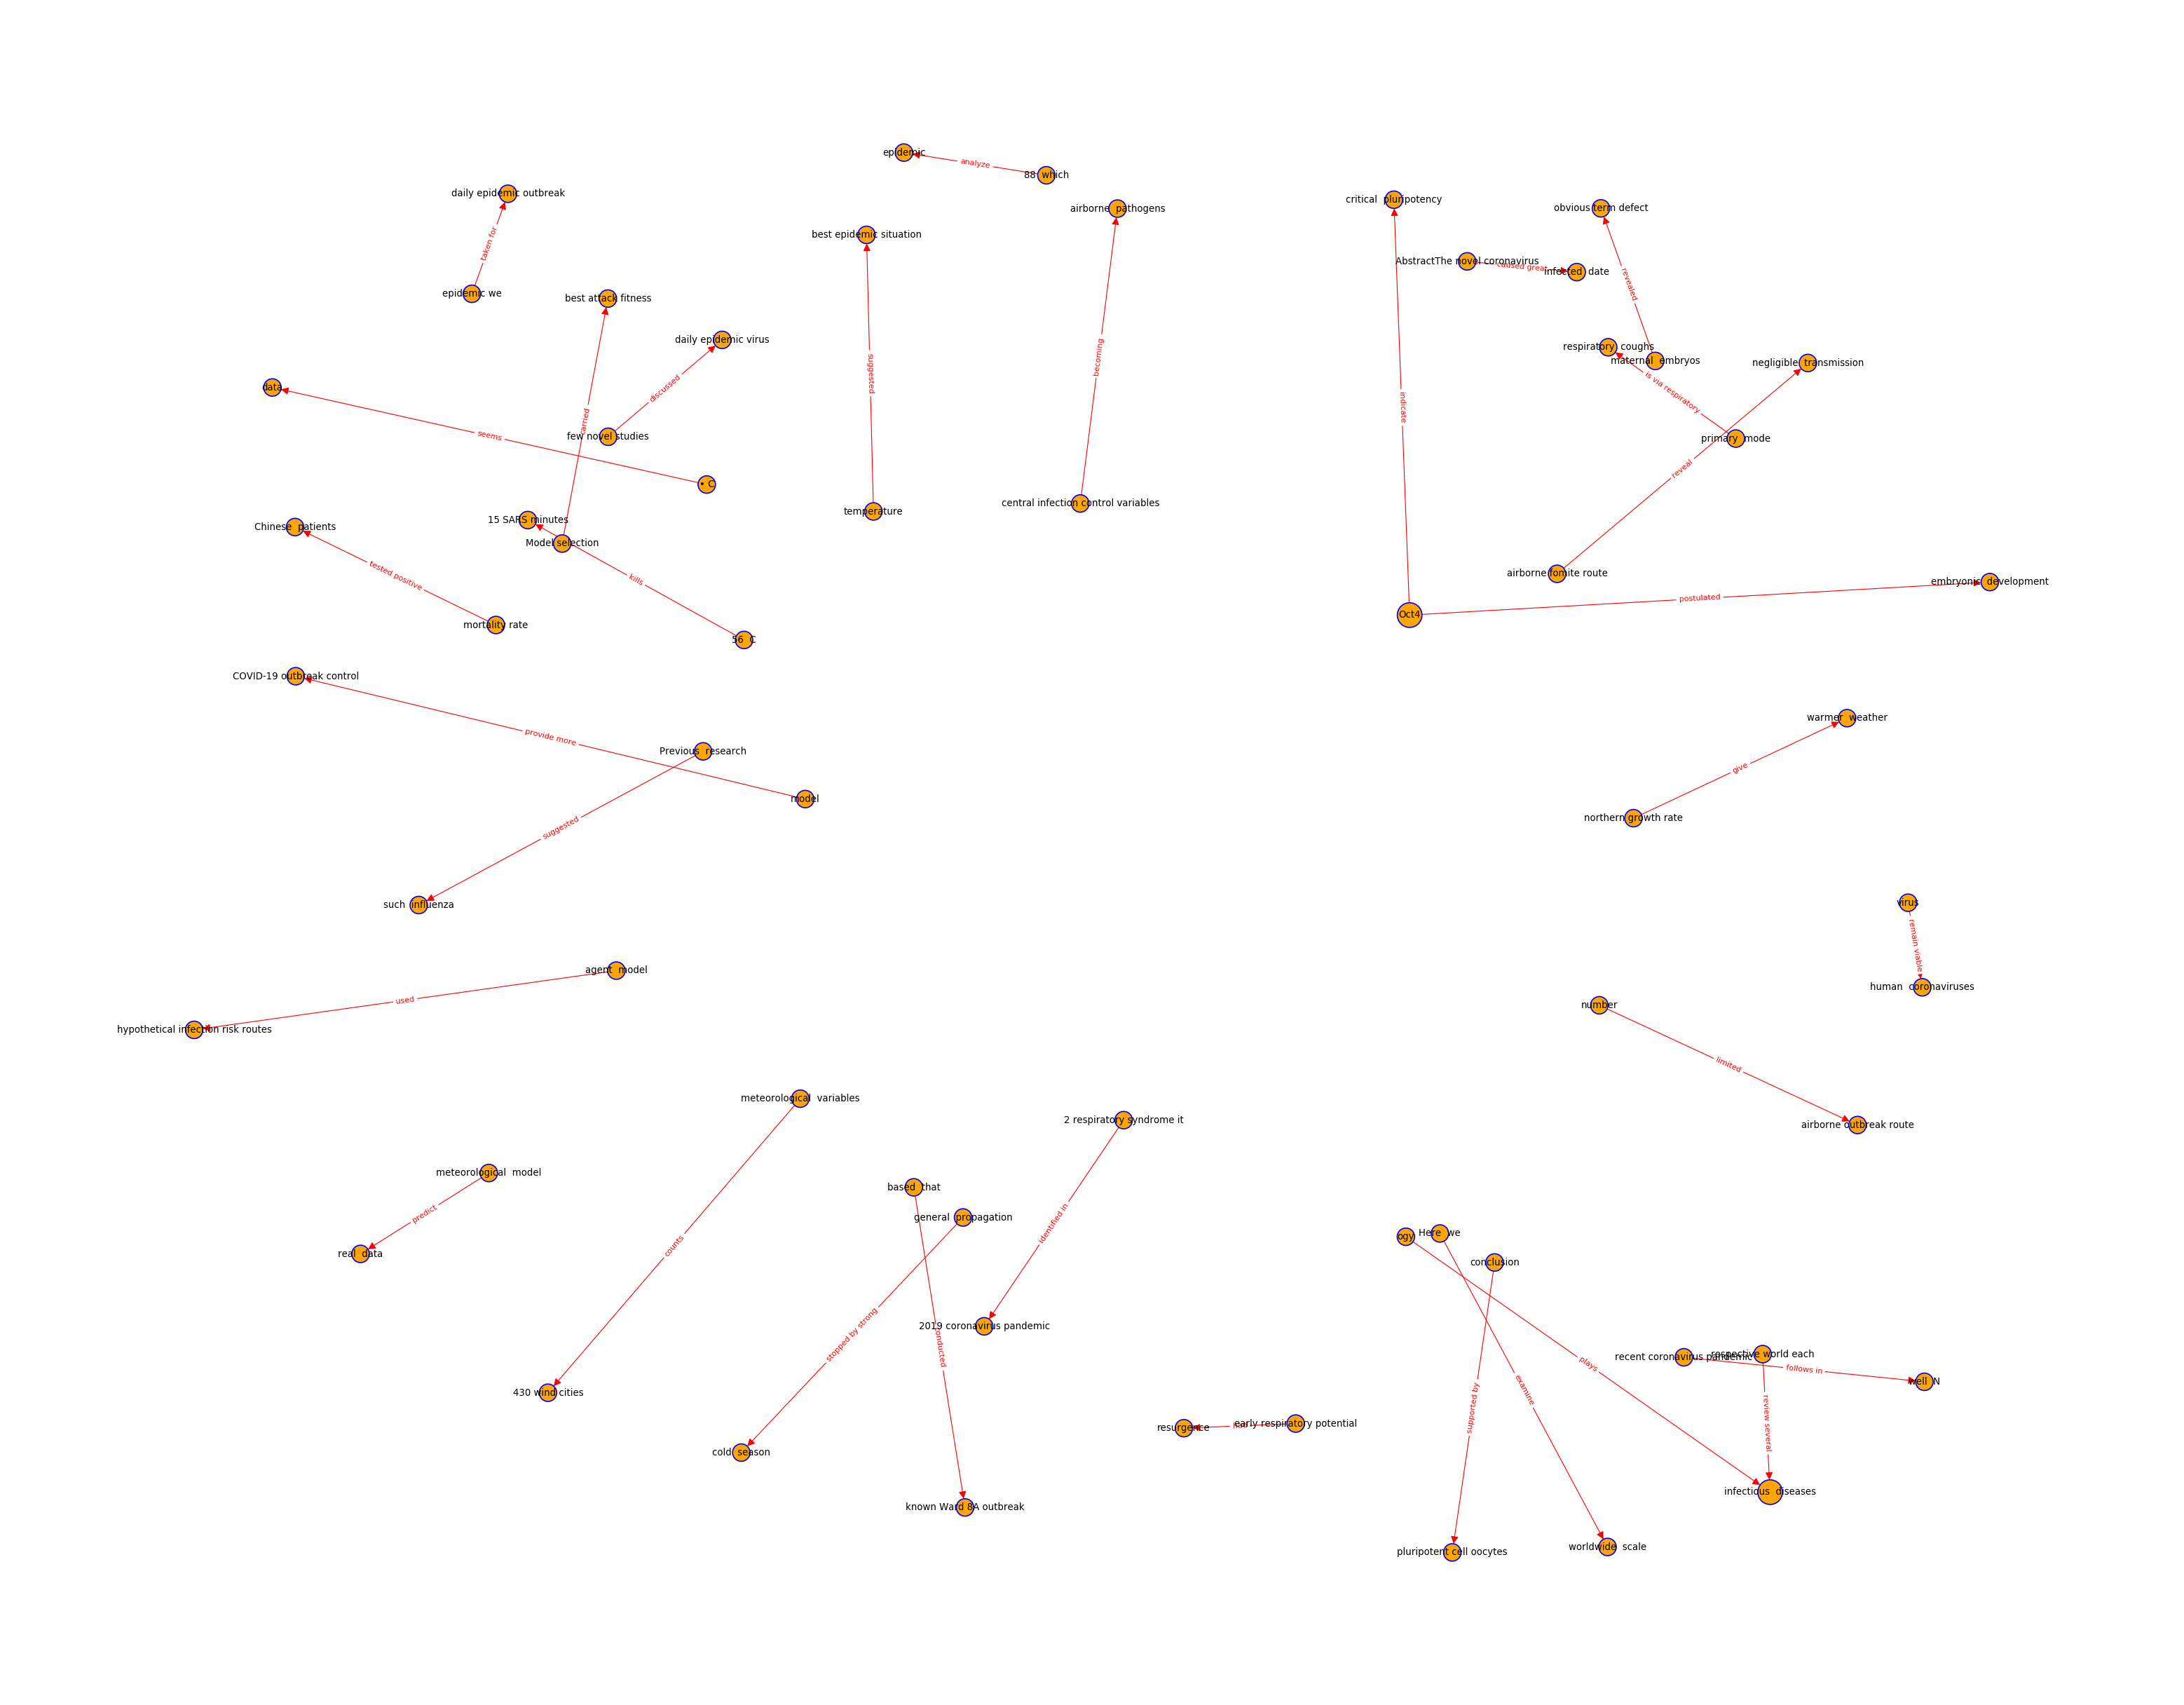

In [58]:
draw_kg(df)

### <font size='3' color='red'>What is known about transmission, incubation, and environmental stability? </font>

### 获取相似文献

In [59]:
sentence= "What is known about transmission, incubation, and environmental stability"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)


### 准备相似摘要和标题

In [60]:
ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])

In [61]:
texts=list(map(clean,texts))
text_list=' '.join(texts)

### 获取主题、关系和对象的数据框，用来绘制知识图谱。

## 绘制知识谱图

待查询内容: 我们对 COVID-19 风险因素了解多少？(What do we know about COVID-19 risk factors?)

* 标题: What Should Gastroenterologists and Patients Know About COVID-19?
* 提取方法: 知识图谱和BERT
* 三个相似段落:
    * 段落1: COVID-19 is a respiratory illness caused by a novel coronavirus that was first identified in Wuhan, the capital city of China's Hubei Province, in December 2019. 1 Initially referred to as the 2019 novel coronavirus (2019-nCoV), COVID-19 is caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). 2 It was identified by researchers at the Wuhan Institute of Virology through metagenomic analysis of a bronchoalveolar lavage sample from a patient in the initial cluster of pneumonia cases in that city. 3 Coronaviruses are a large family of RNA viruses that are known to cause illnesses ranging from the common cold to more severe diseases such as Middle East Respiratory Syndrome (MERS) and Severe Acute Respiratory Syndrome (SARS). The SARS-CoV-2 virus shares 79.5% of the genetic sequence of SARS and has 96.2% homology to bat coronavirus. 4 The intermediate animal vector between bats and humans for SARS-CoV-2 is currently unknown but has been linked epidemiologically to the Huanan Seafood Wholesale Market. 5 Although initially a zoonotic virus, SARS-CoV-2 is now spread human-to-human with higher infectivity than MERS and SARS but a lower fatality rate. 3 The clinical presentation of COVID-19 can range from mild non-specific respiratory symptoms to severe organ dysfunction such as acute respiratory distress syndrome (ARDS) that can lead to death. 1,6,7 Most cases of COVID-19 appear to be mild with the most common symptoms being fever (83-98%), cough (46-82%), myalgia/fatigue (11-44%), and shortness of breath (31%). 7 Risk factors for more severe illness requiring hospitalization appear to be older age and having underlying chronic medical conditions such as diabetes, lung disease and cardiovascular disease. 7 Early reports suggest that for more severe cases the median time from first symptom onset to the development of shortness of breath and/or need for hospitalization ranged from 5 to 8 days. 6-8 Among hospitalized COVID-19 patients, it is reported that 5 to 26.1% have required admission to the intensive care unit. 6, 8 The reported fatality rate for hospitalized COVID-19 patients has ranged from 1.4 to 15%. The incubation period for SARS-CoV-2 appears to average 5.2 days but may range from 2 to 14 days and potential asymptomatic infection has been reported. 7, 9 Of note for gastroenterologists, patients may complain of gastrointestinal symptoms such as nausea or diarrhea. 7 In the prior SARS coronavirus outbreak, diarrhea was reported in up to 25% of patients. 11 Interestingly, the cell entry receptor ACE2 appears to mediate entry of SARS-CoV-2 (similar to SARS) and has been demonstrated to be highly expressed in small intestinal enterocytes. 11 ACE2 is important in controlling intestinal inflammation and its disruption may lead to diarrhea. 11 The reported frequency of diarrhea among COVID-19 patients has varied from 2 to 33% and was one of the prominent symptoms reported by the first case in the United States. 11,12 SARS-CoV-2 has been detected in the stool of COVID-19 patients. 12, 13 So while COVID-19 appears to primarily spread through respiratory droplets and secretions, the gastrointestinal tract may be another potential route of infection, highlighting importance of personal protective equipment during endoscopy. Further, some of the more common laboratory findings described in COVID-19 patients include liver function test abnormalities. In addition to leukopenia (reported in 9-25% of cases) or leukocytosis (24-30%), elevated alanine aminotransferase and aspartate aminotransferase have been seen in up to 37% of cases. More recent descriptions of patients in China also noted around 10% of patients were also noted to have elevated total bilirubin levels. 8 Gastroenterologists should be aware of these potential gastrointestinal manifestations of COVID-19.
    * 段落1: COVID-19** has been of particular interest to our patients on immunosuppressive agents (immunomodulators or biologics) such as those with inflammatory bowel disease (IBD). COVID-19 has now been reported throughout the world, with more reported cases on a daily basis. We therefore aim to provide a brief overview of COVID-19 for the gastroenterology community based on currently available information to help assist with addressing our patients' questions and concerns
    * 段落1: Measures to control the spread of COVID-19 are similar to the general advice for preventing any respiratory viral illness. At the national and international level, travel restrictions have been implemented for regions with the highest COVID-19 incidence currently, but these recommendations and polices are likely to rapidly change and warrant close monitoring. Patients with potential symptoms of COVID-19 with recent travel to areas of higher incidence (China, South Korea, Japan, Iran, and Italy based on the most recent CDC data) should be asked to wear a standard surgical mask as soon as they are identified and be placed in a private room with the door closed, ideally an airborne isolation room (negative-pressure room). 3, 7 It is important to note that travel history criteria for testing for COVID-19 will change as community-based spread is emerging within the United States and patients living in or with recent travel to areas where COVID-19 has been confirmed should be considered for testing as well. Any concern for possible COVID-19 should immediately prompt notification of institutional infection prevention and control as well as local or state health departments. Healthcare personnel entering the room should use standard precautions, contact precautions (gown and gloves), airborne precautions (with N95 respirator), and eye protection (goggles or a face shield). Testing has been performed at the Centers for Disease Control and Prevention (CDC) but is now more widely available in state and city laboratories and is becoming available commercially. It is important that more common respiratory illnesses (influenza, etc.) are also ruled out. What should we tell our patients based on our current knowledge? First, this is a rapidly evolving area with new information emerging on a daily basis. Therefore periodically checking on recommendations from leading national and international health organizations, such as the CDC or the World Health Organization (WHO), is the most important way for both patients and physicians to stay informed with accurate information. Second, it is important to realize that the majority of cases (80+%) have been mild, the fatality rate for COVID-19 is lower than prior coronavirus outbreaks, and the proportion of severe/fatal cases may be an overestimate as milder or asymptomatic cases are likely under-reported. 15 Third, there are currently no specific recommendations for people on immunosuppression, such as IBD patients. Prior IBD research has found that viral infections are more likely among patients on immunomodulators (such as 6-mercaptopurine and azathioprine) than those on biologics but it is unclear if this can be extended to COVID-19. 16 There are no data currently about the impact of immunosuppressive agents, although one of the largest case series from China did note that 2 patients with immunodeficiency (not further specified) had non-severe disease. 8 17 Last, the best measures to decrease the **risk** of contracting SARS-CoV-2 are the same as standard practices against any viral illness. These include good hand hygiene with alcohol-based hand sanitizers or soap and water, covering your mouth and nose with a tissue or your sleeve (not your hands) when coughing or sneezing, limiting touching your face, avoiding close contact with anyone with influenza-like and/or upper respiratory symptoms, and staying home if you are sick.


In [63]:
sentence= "What do we know about COVID-19 risk factors"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,8)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

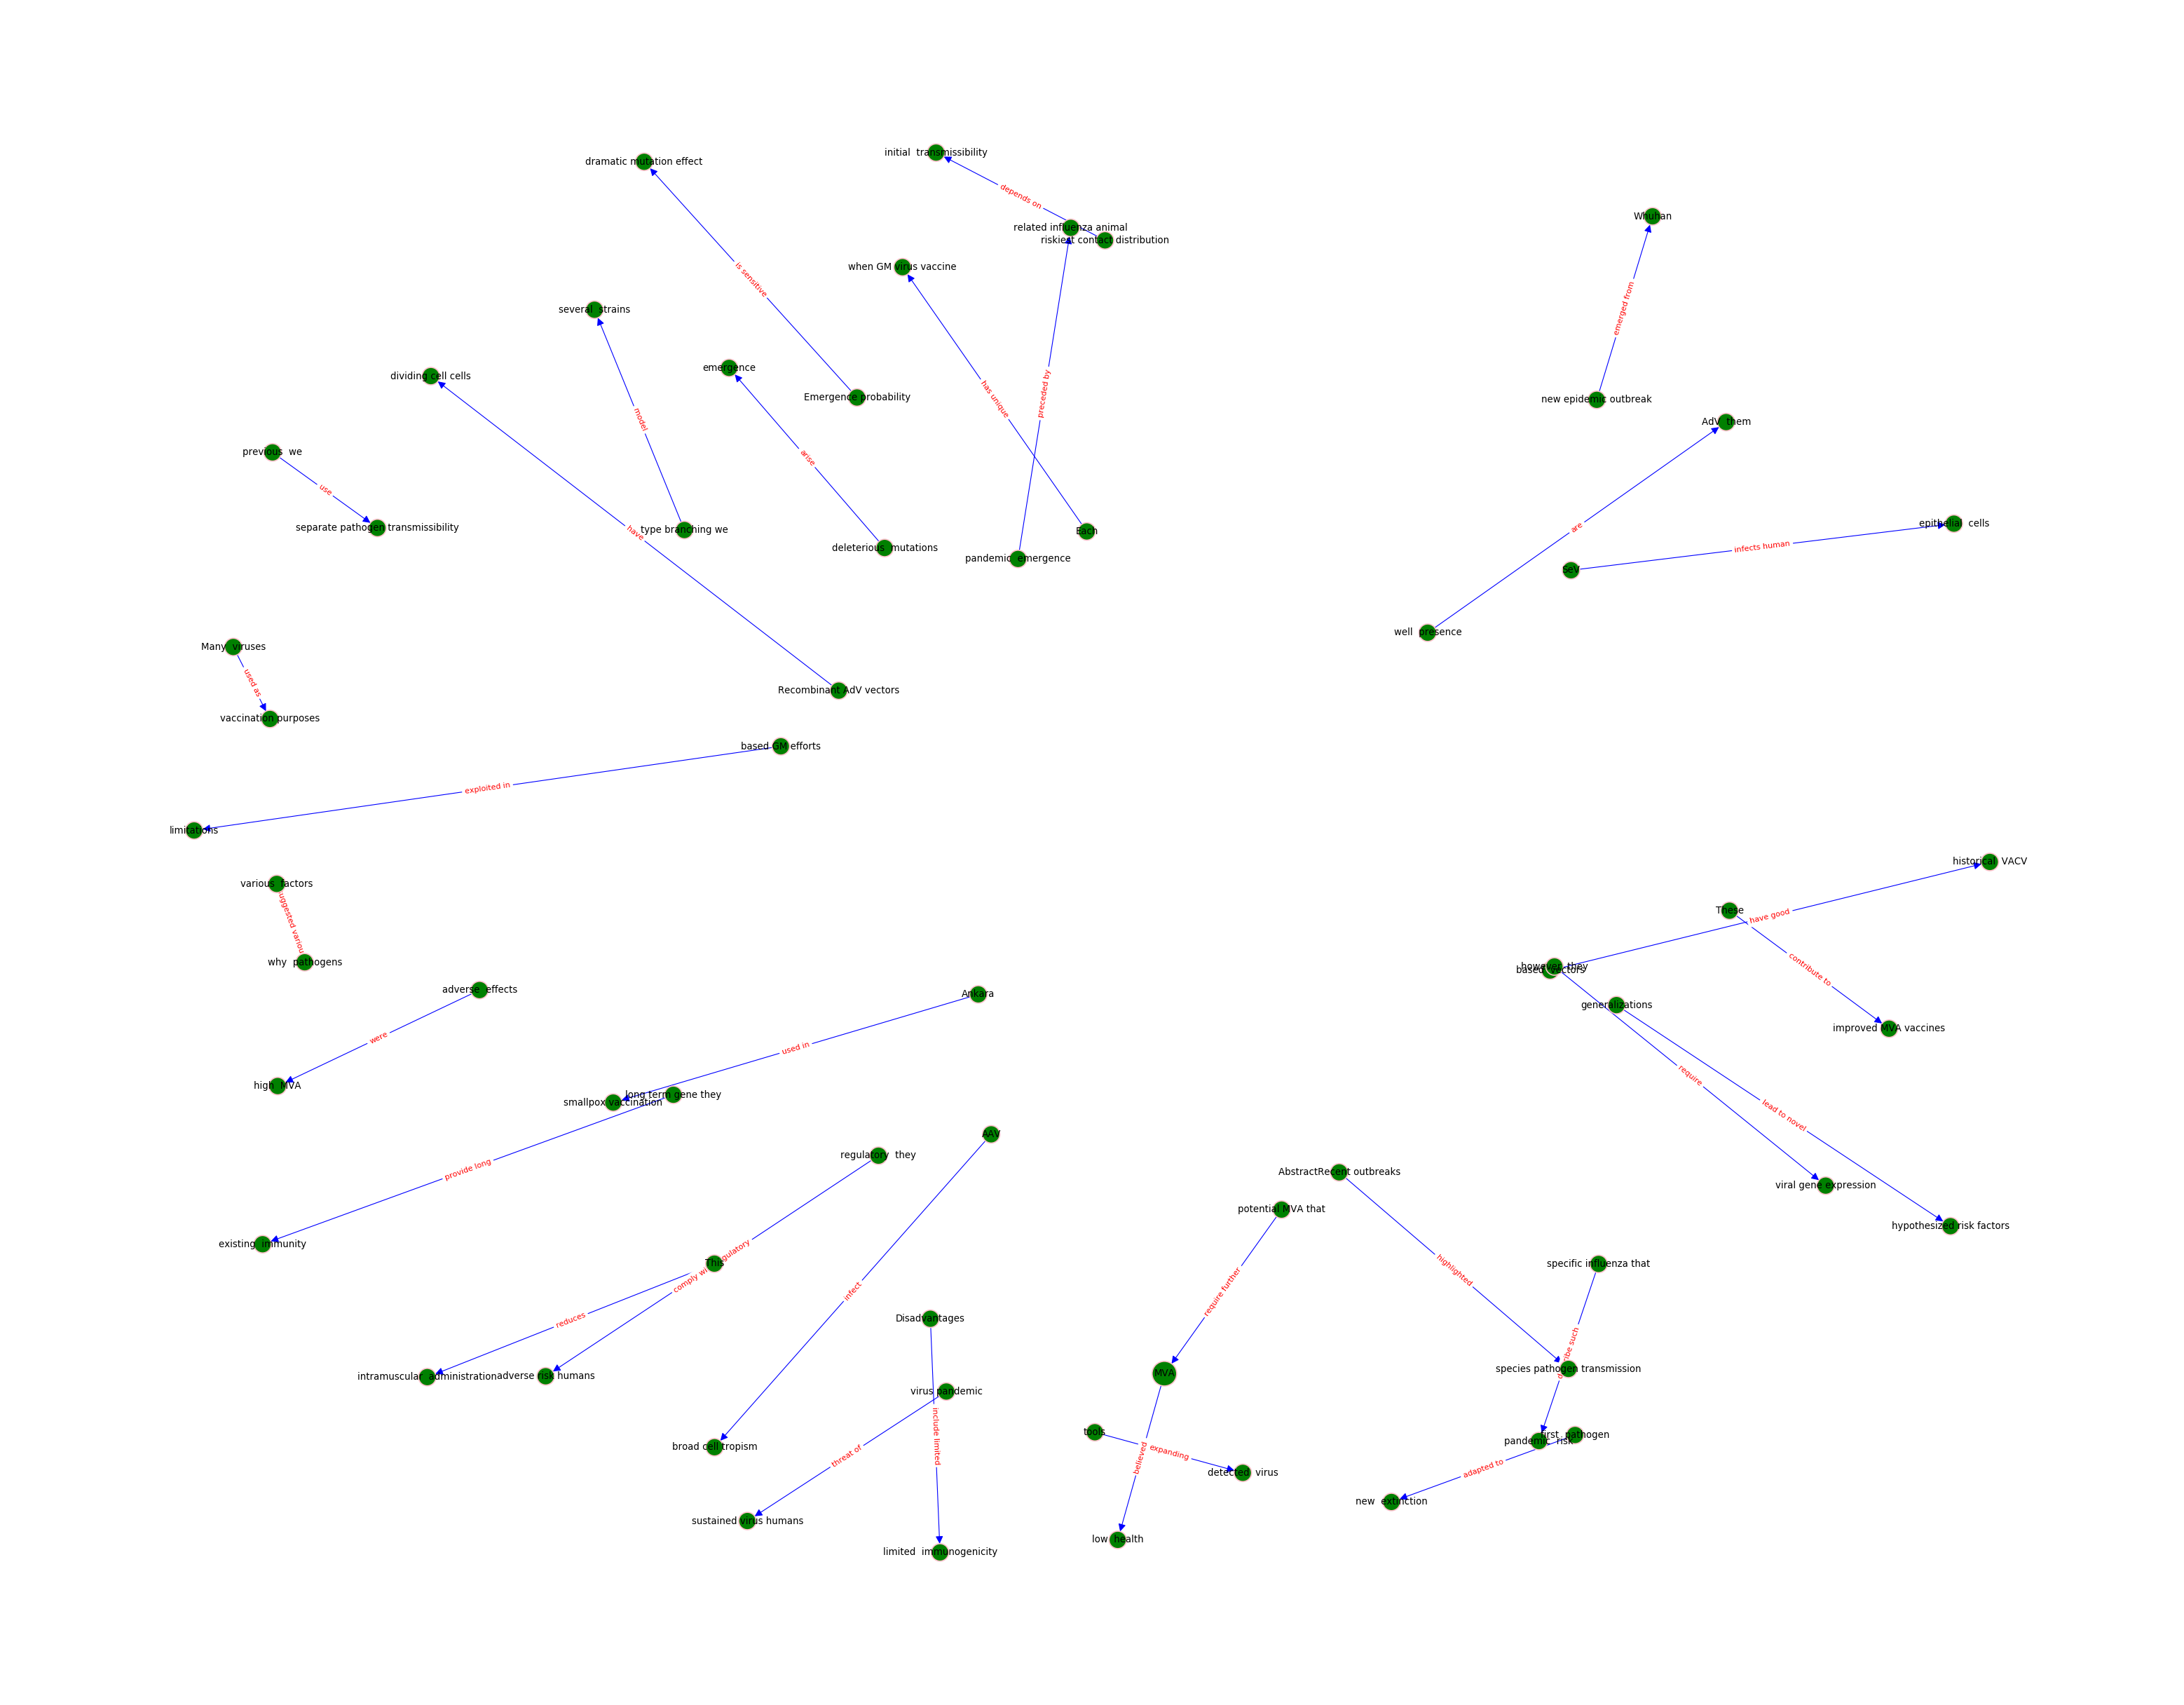

In [64]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

待查询内容：我们对病毒的遗传学、起源和进化了解多少？(What do we know about virus genetics, origin, and evolution?)

* 标题：When Darkness Becomes a Ray of Light in the Dark Times: Understanding the COVID-19 via the Comparative Analysis of the Dark Proteomes of SARS-CoV-2, Human SARS and Bat SARS-Like Coronaviruses
* 提取方法：知识图谱
Entity extraction method:  Knowledge Graph
* 三个相似段落：
    * 段落1：The copyright holder for this preprint (which was not peer-reviewed) is the . https://doi.org/10.1101/2020.03.13.990598 doi: bioRxiv preprint Non-structural protein 2 (Nsp2). This protein functions by disrupting the host survival pathway via interaction with the host proteins Prohibitin-1 and Prohibitin-2 [128] . Reverse genetic deletion in the coding sequence of Nsp2 of the SARS virus attenuated little viral growth and replication and allowed the recovery of mutant virulent viruses. This indicates the dispensable nature of the Nsp2 protein for SARS viruses [129] . The sequence identity of the Nsp2 protein from SARS-CoV-2 with Nsp2s of Human SARS CoV and Bat CoV amounts to 68.34% and 68.97%, respectively (Supplementary Figure  S2A) . We have estimated the mean PPIDs of Nsp2s of SARS-CoV-2, Human SARS CoV, and Bat CoV to be 5.17%, 2.04%, and 2.03% respectively (see Table 3 ). The per-residues predisposition for the intrinsic disorder of Nsp2s from SARS-CoV-2, Human SARS CoV, and Bat CoV are depicted in Figures 20A, 20B, and 20C . According to this analysis, the following regions in Nsp2 proteins are predicted to be disordered, residues 570-595 (SARS-CoV-2), residues 110-115 (Human SARS), and residues 112-116 (Bat CoV). As listed in Table 2 , and Supplementary Tables 7 and 8, Human SARS CoV does not contain MoRF while SARS-CoV-2 and Bat CoV have an N-terminally located MoRF region predicted by MoRFchibi_web.
    * 段落2：The emergence of new viruses and associated deaths around the globe represent one of the major concerns of modern times. Despite its pandemic nature, there is very little information available in the public domain regarding the structures and functions of SARS-CoV-2 proteins. Based on its similarity with Human SARS CoV and Bat CoV, the published reports have suggested the functions of SARS-CoV-2 proteins. In this study, we utilized information available on SARS-CoV-2 genome and translated proteome from GenBank, and carried out a comprehensive computational analysis of the prevalence of the intrinsic disorder in SARS-CoV-2 proteins. Additionally, a comparison was also made with proteins from close relatives of SARS-CoV-2 from the same group of beta coronaviruses, Human SARS CoV and Bat CoV. Our analysis revealed that in these three CoVs, the N proteins are highly disordered, possessing the PPID values of more than 60%. These viruses also have several moderately disordered proteins, such as Nsp8, Orf6, and Orf9b. Although other proteins have shown lower disorder content, almost all of them contain at least some IDPRs, and all CoV proteins author/funder. All rights reserved. No reuse allowed without permission.
    * 段落3：Supplementary Figures S1. Multiple sequence alignment of structural proteins of all three studied coronaviruses are generated using Clustal Omega. The aligned images are created using Esprit 3.0. Figure S1A . MSA of SARS-CoV-2, Human SARS, and Bat CoV spike glycoproteins. Figure S1B . MSA of SARS-CoV-2, Human SARS, and Bat CoV Nucleoproteins.


In [65]:
sentence= "What do we know about virus genetics, origin, and evolution"

similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

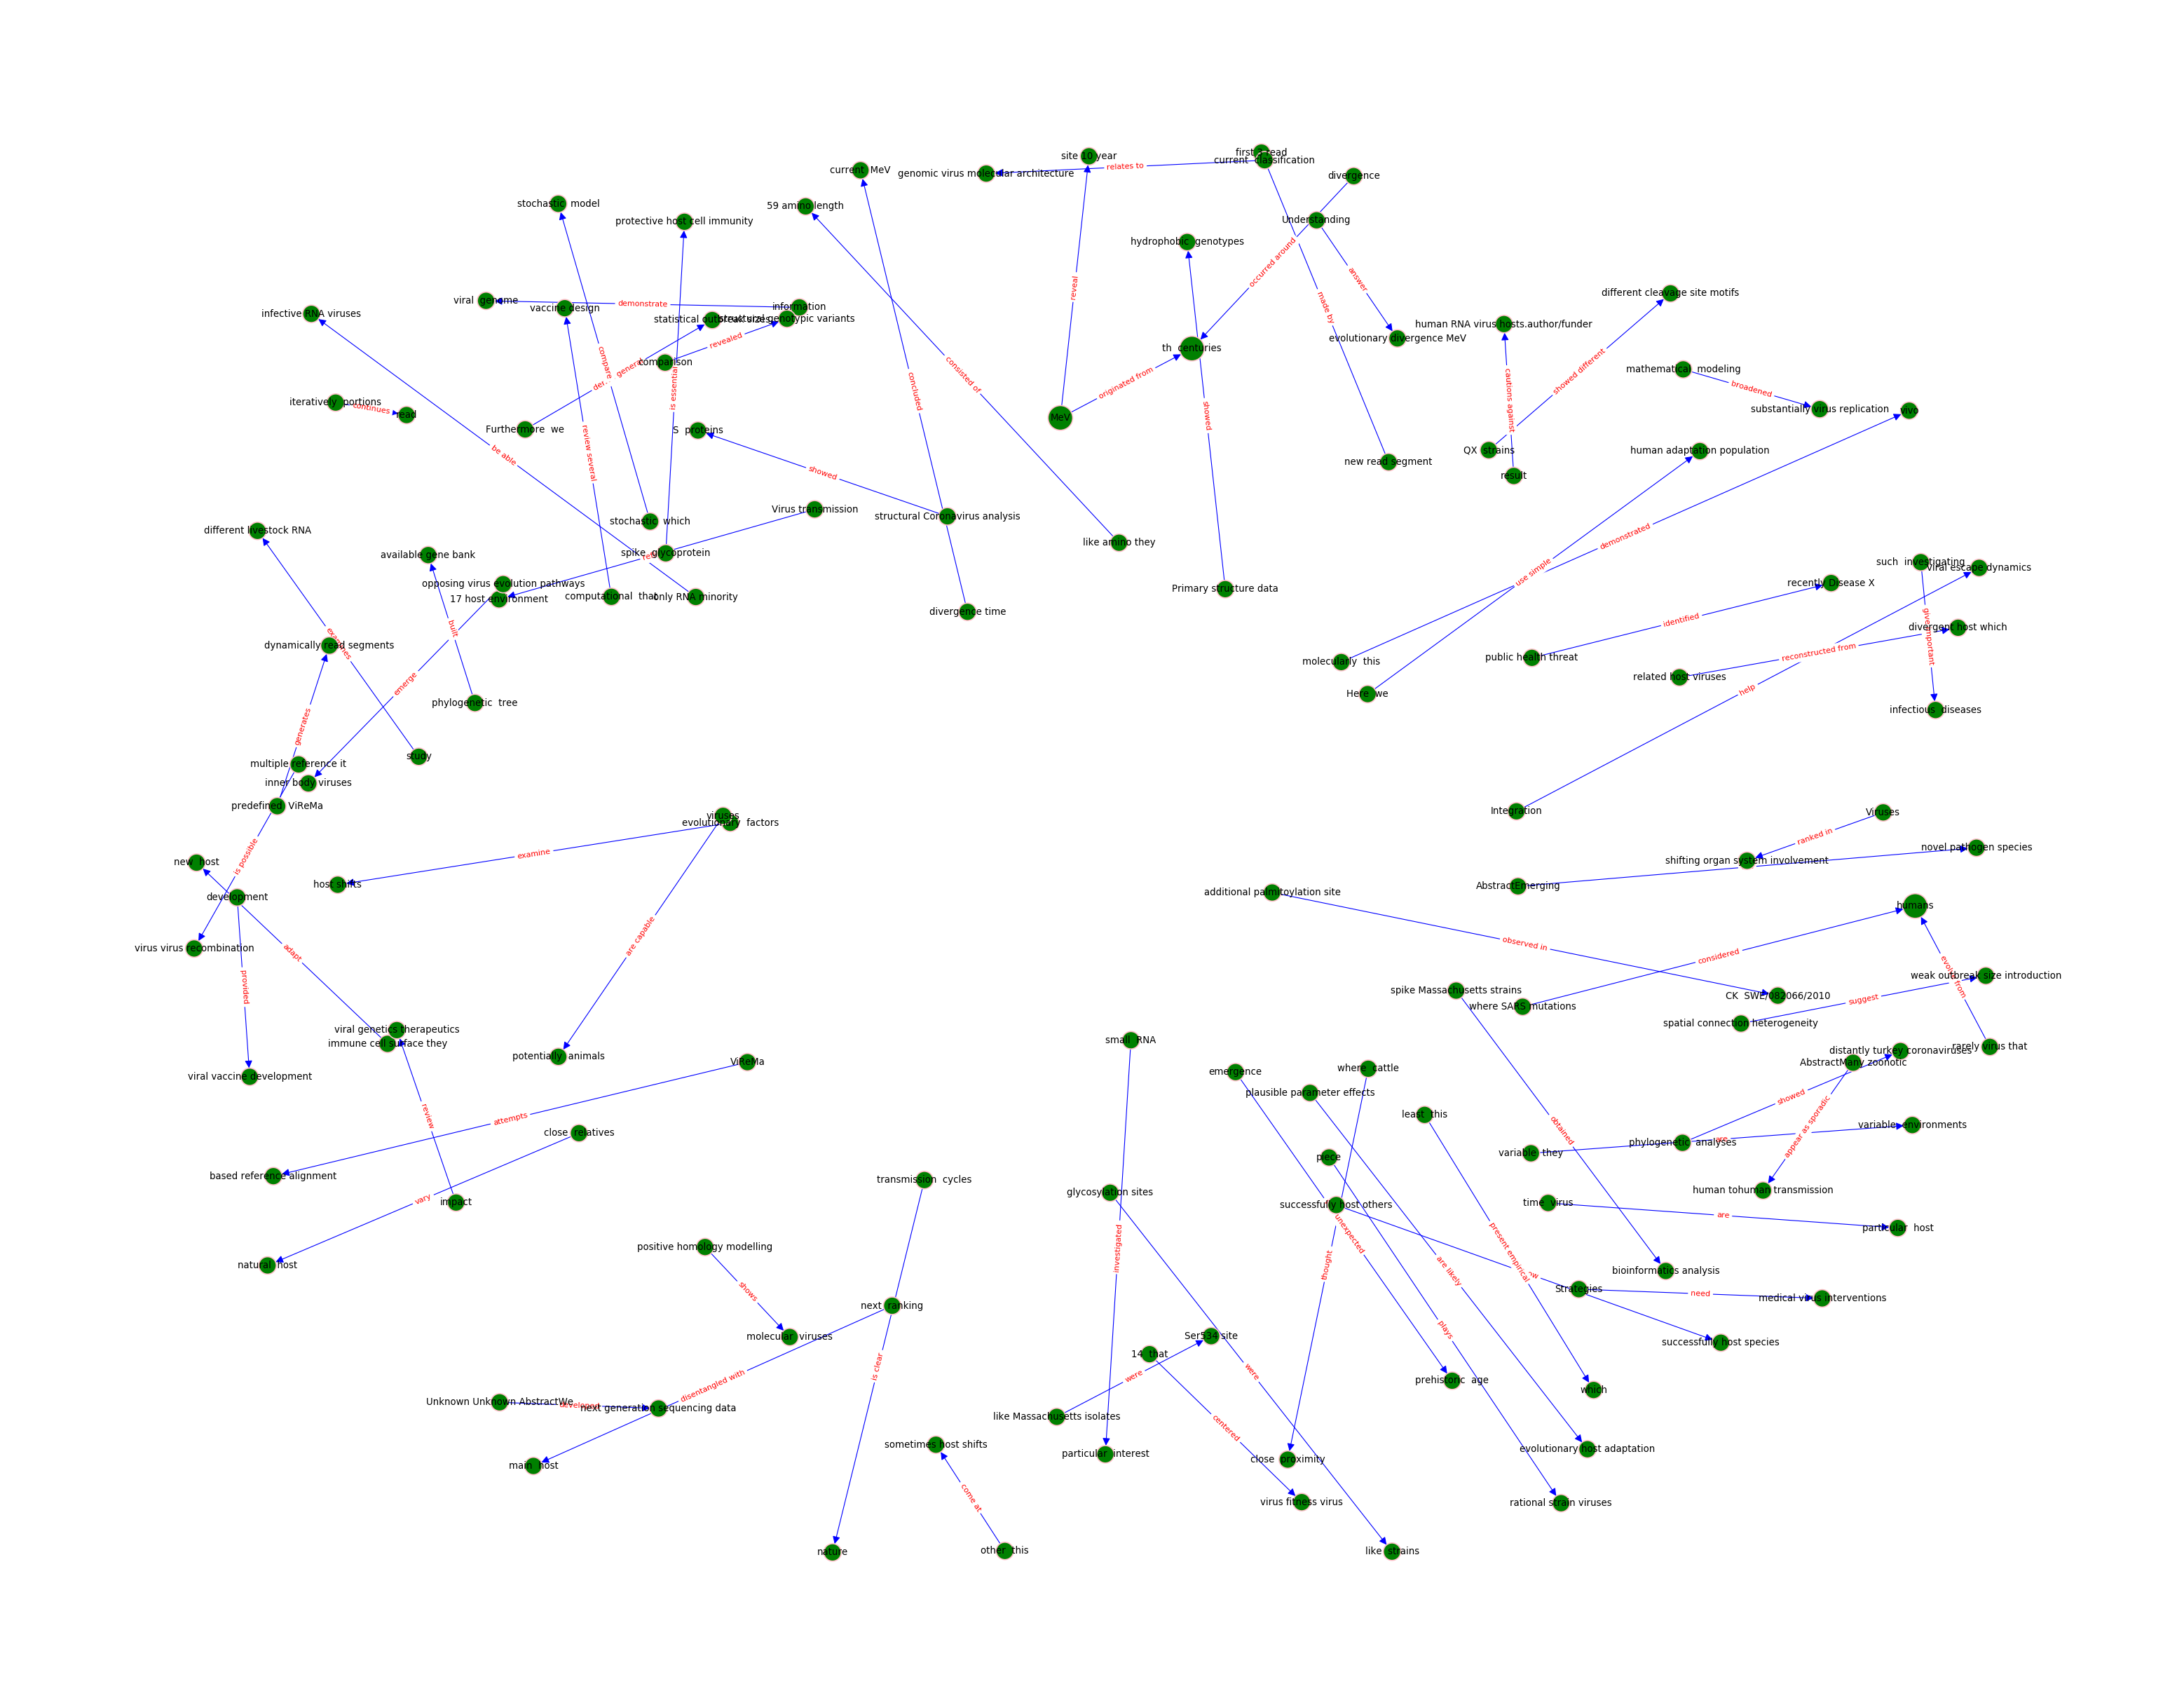

In [66]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

### <font size='3' color='red'>What do we know about vaccines and therapeutic?</font>
待查询内容：What do we know about vaccines and therapeutic?(我们对疫苗和疗法了解多少？)

* 标题：Financing Vaccines for Global Health Security
* 提取方法：知识图谱
* 三个相似段落：
    * 段落1：In spite of these substantial difficulties-or perhaps because of them-new global initiatives have drawn attention to the need for new approaches to encourage the development of vaccines against EIDs (16, 17) . International collaborations like CEPI have drawn extensive public, private, NGO, and academic attention to the perils of global epidemic unpreparedness (18) .
    * 段落2：Vaccines only sell for a fraction of their economic value, in some cases for only a few dollars. They provide myriad benefits, like enabling would-be patients to live longer, healthier lives (33, 34) , and bearing yet-undervalued gains in productivity and positive externalities to society at large (35) (36) (37) . Although the low price of vaccines is meant to benefit individuals and regions with lower incomes, in the long run, it has had the opposite effect, causing them to be medically underserved due to a lack of vaccine investment. Pharmaceutical companies and investors are directing their resources to projects in which the estimated return on investment is more predictable and lucrative. Vaccine prices are currently set far below the prices of drugs that treat other serious conditions, such as cancer, despite the enormous societal value of vaccines in general, and those to ensure global health security in particular.
    * 段落3：This crisis-driven expanded interest in vaccines to address epidemic threats is encouraging, but there is still much work to be done. There needs to be a viable, sustainable business model that will align the financial incentives of stakeholders to encourage the necessary investment in vaccine development (19, 20) . While governments and international agencies have striven to create incentives to attract additional private sector investment in vaccine development, these efforts have so far failed in attracting sufficient capital to enhance preparedness against the world's most deadly emerging pathogens (21) .

In [67]:
sentence= "What do we know about vaccines and therapeutics"

similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

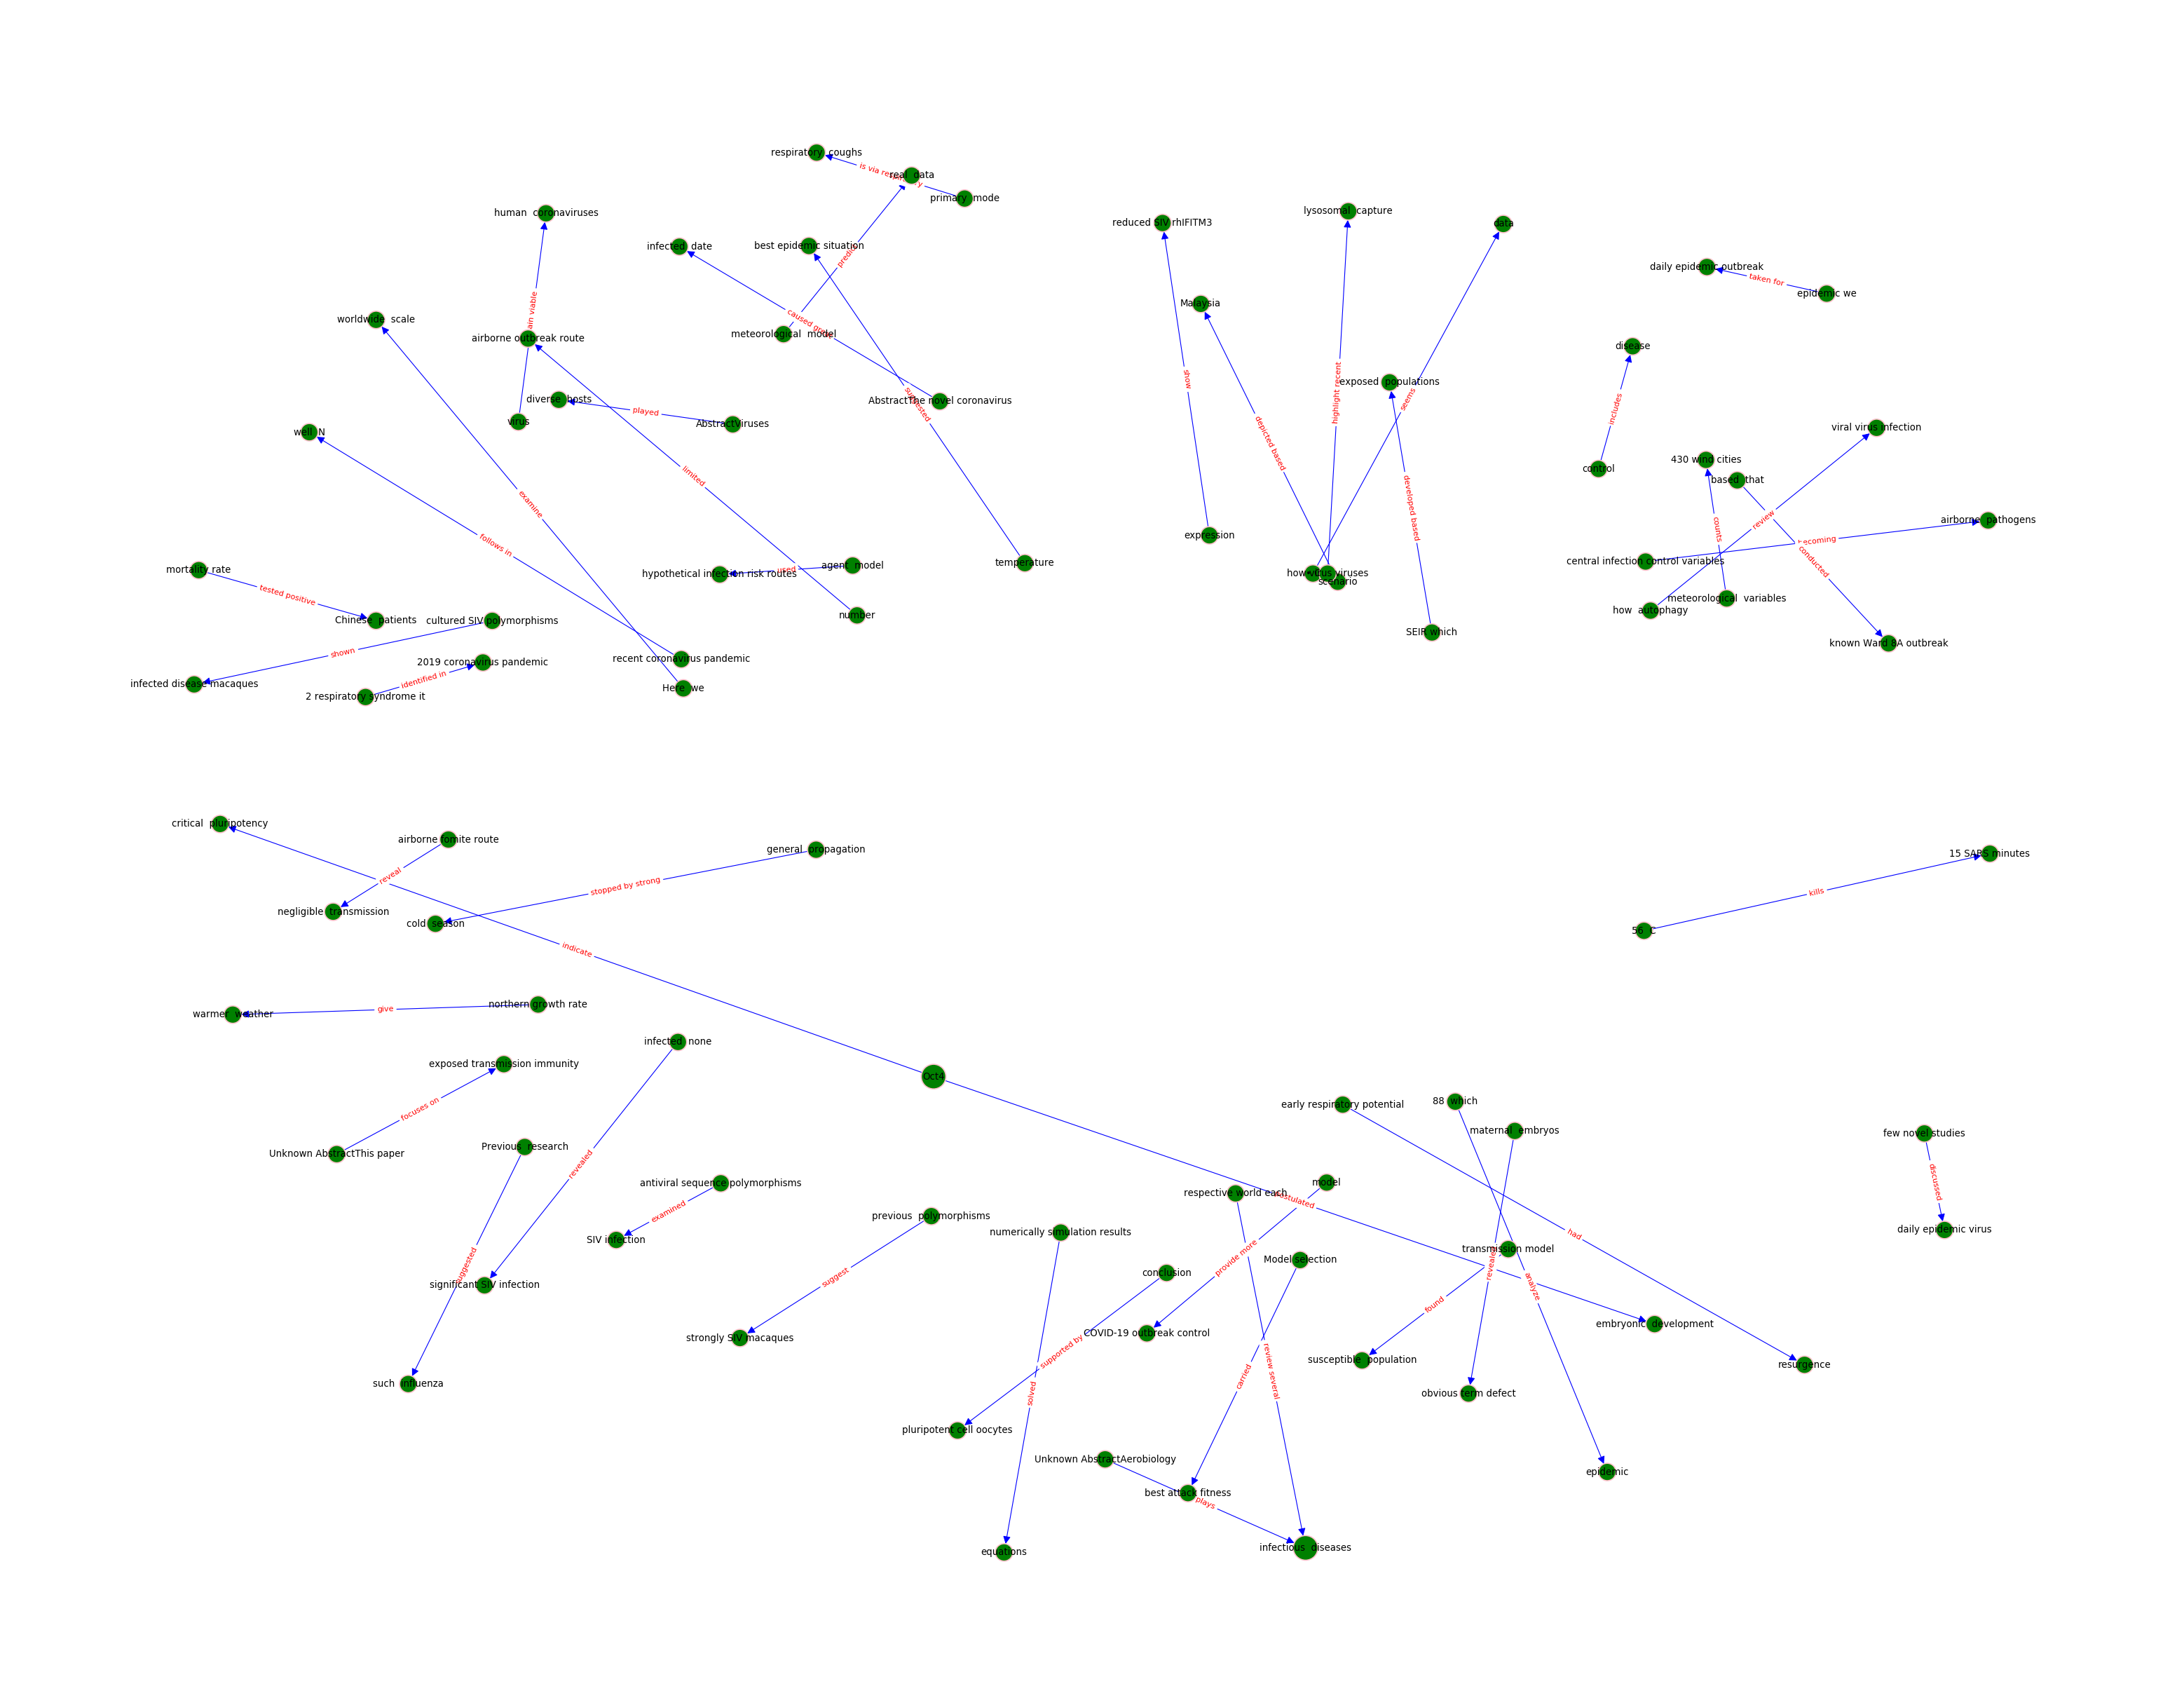

In [70]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

待查询内容：What do we know about non-pharmaceutical interventions?(我们对非药物干预了解多少？)

* 标题：What does simple power law kinetics tell about our response to coronavirus pandemic?
* 提取方法：BERT
* 三个相似段落：
    * 段落1：To the best of my knowledge of the scientific understanding of coronavirus at the point of writing this article,
    * 段落2：The effect of weather on the spread of pandemic has not been established.
    * 段落3：Travel restrictions between countries are very useful in the initial phases of the pandemic but have little effect in the later phases.



In [71]:
sentence="What do we know about non-pharmaceutical interventions"

similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

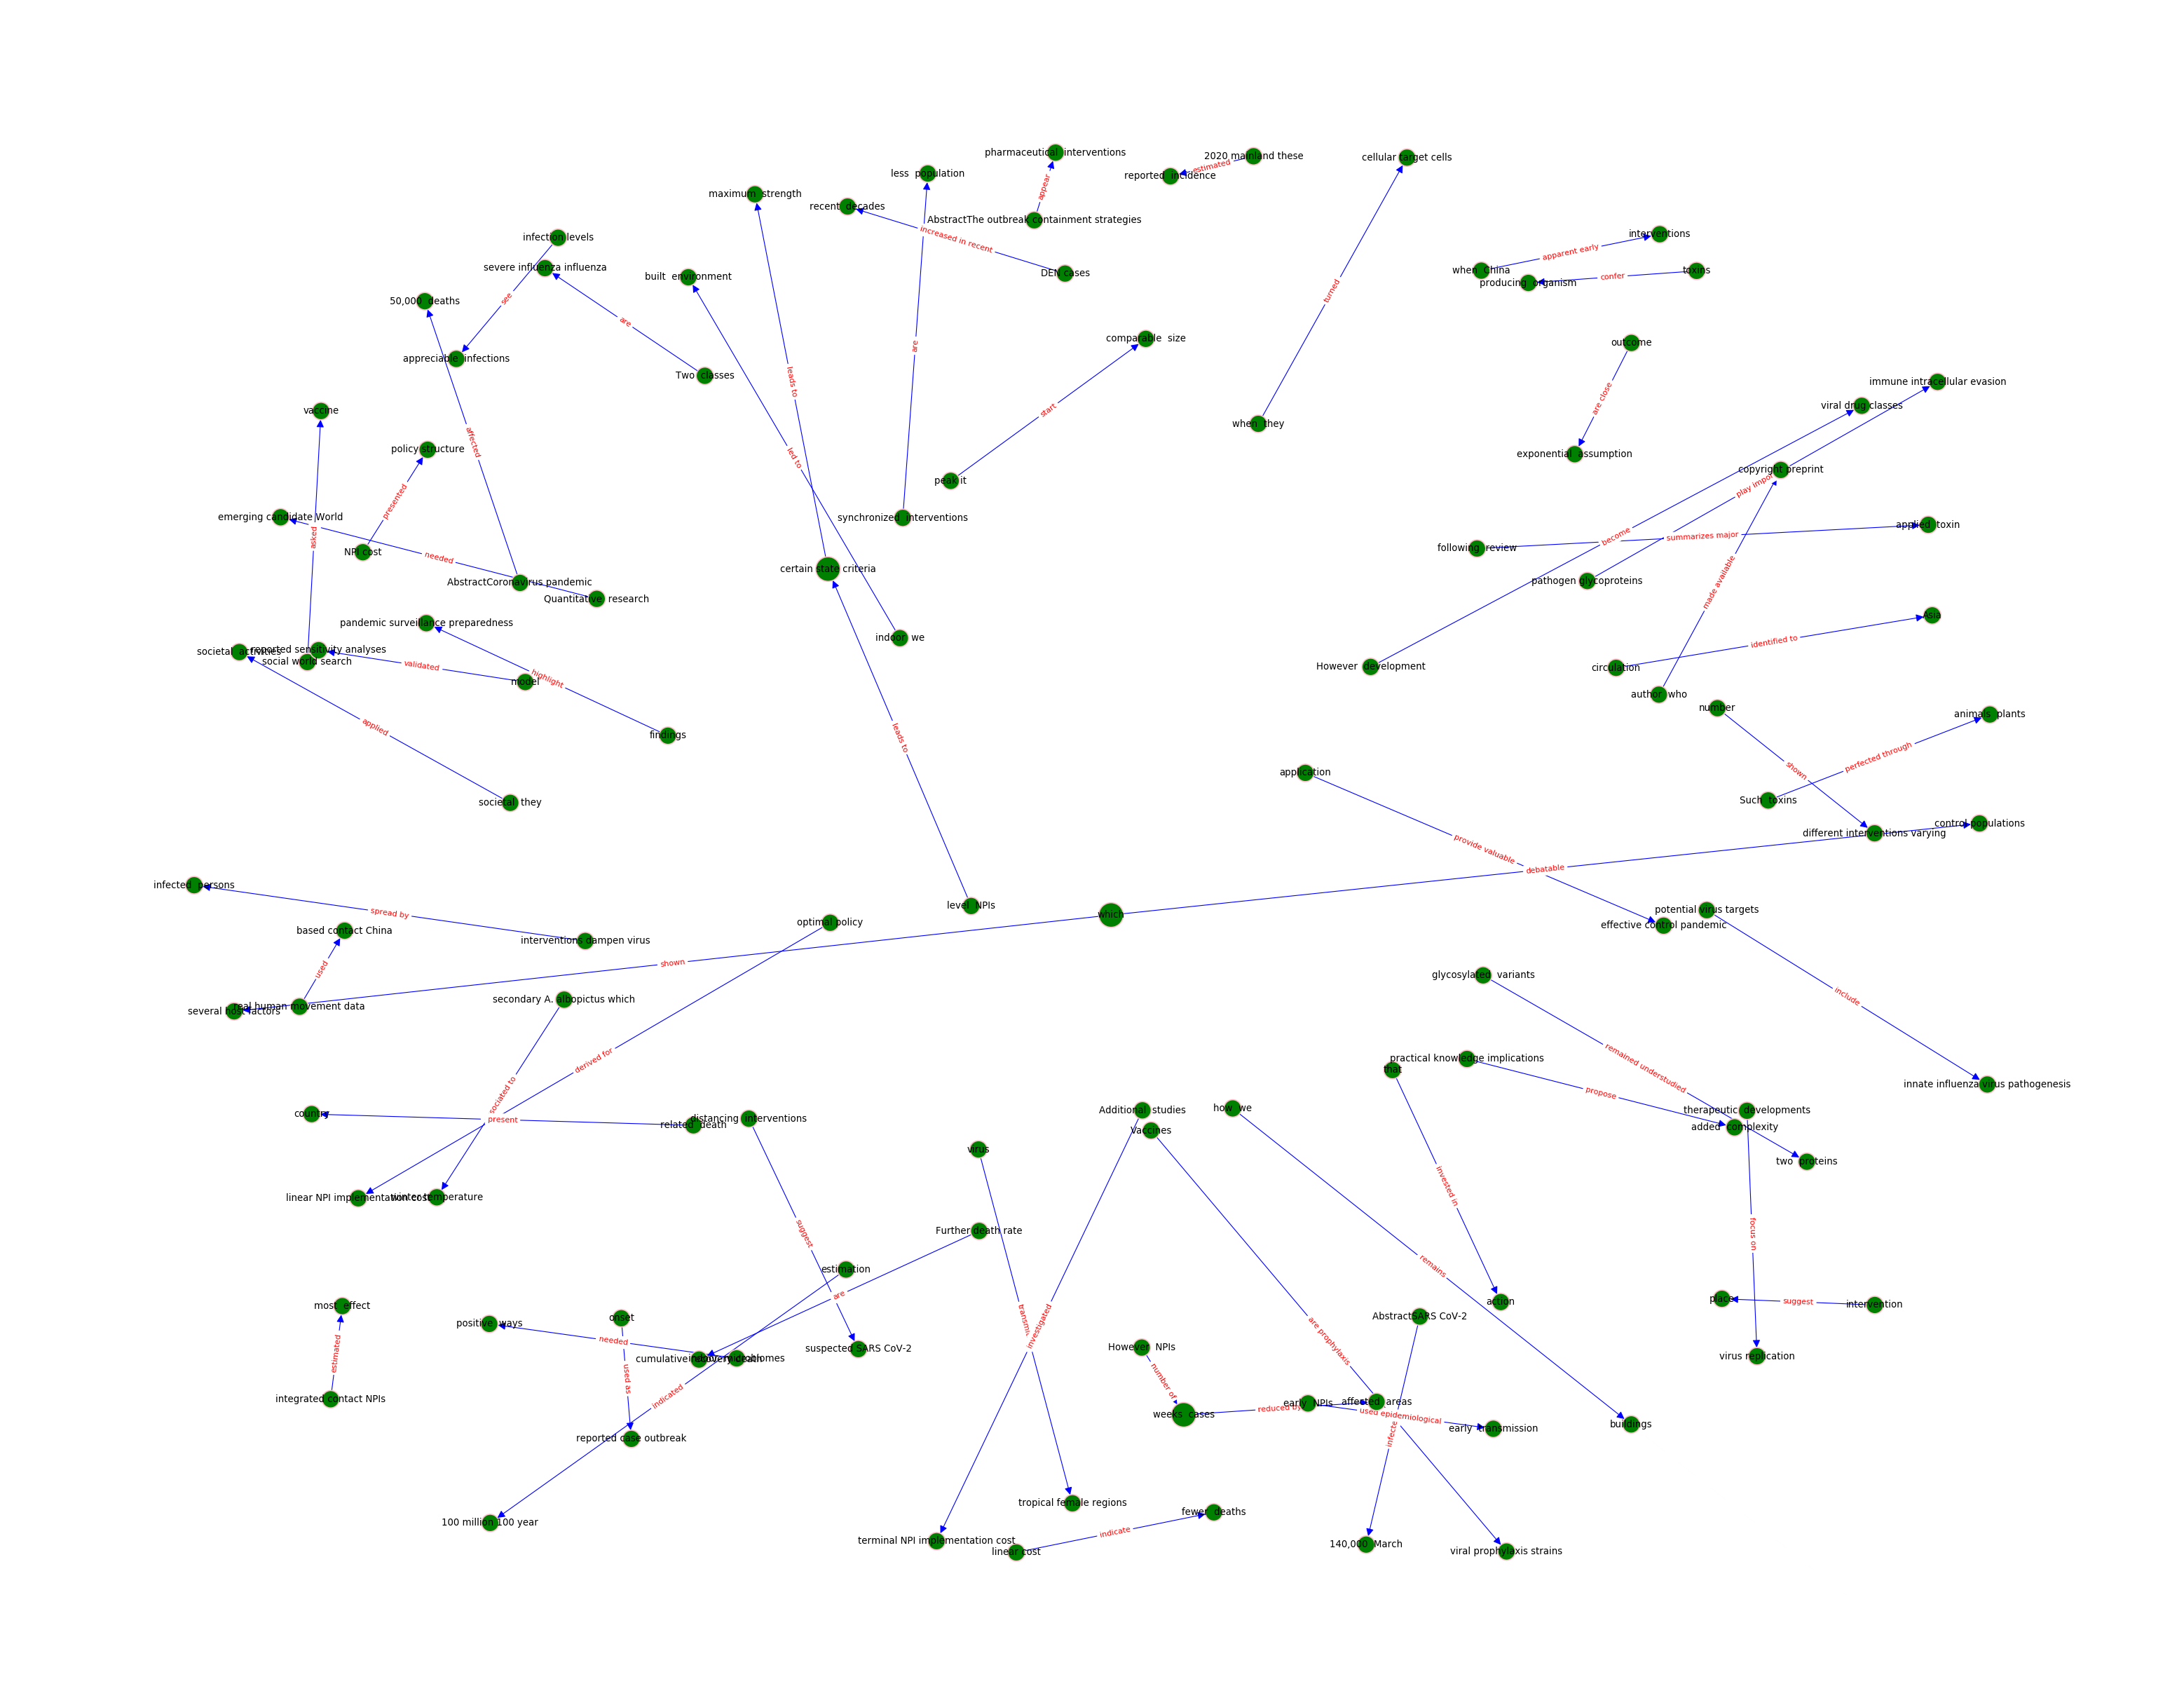

In [72]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

### <font size='3' color='red'>What has been published about ethical and social science considerations?</font>

待查询内容：What has been published about ethical and social science considerations?(关于伦理和社会科学方面的考虑已经发表了什么？)

* 标题：Rapid community-driven development of a SARS-CoV-2 tissue simulator
* 提取方法：知识图谱
* 三个相似段落：
    * 段落1：Open source and GitHub: All simulation source code is shared as open source on GitHub, with welldefined, versioned and documented releases, and Zenodo-generated DOIs and archives. (2) Interactive cloud-hosted models: Every prototype version is rapidly transformed into a cloud-hosted, interactive model to permit faster scientific communication across communities, particularly with virologists and others who have essential insights but ordinarily would not directly run the simulation models. (3) Social media and virtual feedback: We enlist community participation (feedback, modeling contributions, software contributions, and data contributions) through social media, virtual seminars, web-based forms, and a dedicated Slack workspace. We are particularly encouraging feedback and data contributions by domain experts in virology, epidemiology, and mathematical biology (with a focus (4) Frequent preprint updates: Each model iteration is accompanied by a cloud-hosted, interactive app (see #2) and an updated preprint on bioRxiv. (5) Integration of feedback: All community feedback is evaluated to plan the next set of model refinements and recorded in an updated bioRxiv preprint.
    * 段落2：We will gather community consensus and pool efforts into a "standardized" model that captures key SARS-CoV-2 dynamics. We will supply this model to the community for use in parallel studies by multiple labs.
    * 段落3：This rapid prototyping effort brings together specialists from a broad variety of domains: virology and infectious diseases, mathematical biology, computer science, high performance computing, data science, and other disciplines. Therefore, it is critical that all members of the project have access to a clear description of underlying biology. In this section we outline key aspects of viral replication and host response in functional terms needed for development of agent-based, multi-scale and multi-physics models.

In [73]:
sentence= "What has been published about ethical and social science considerations"

similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

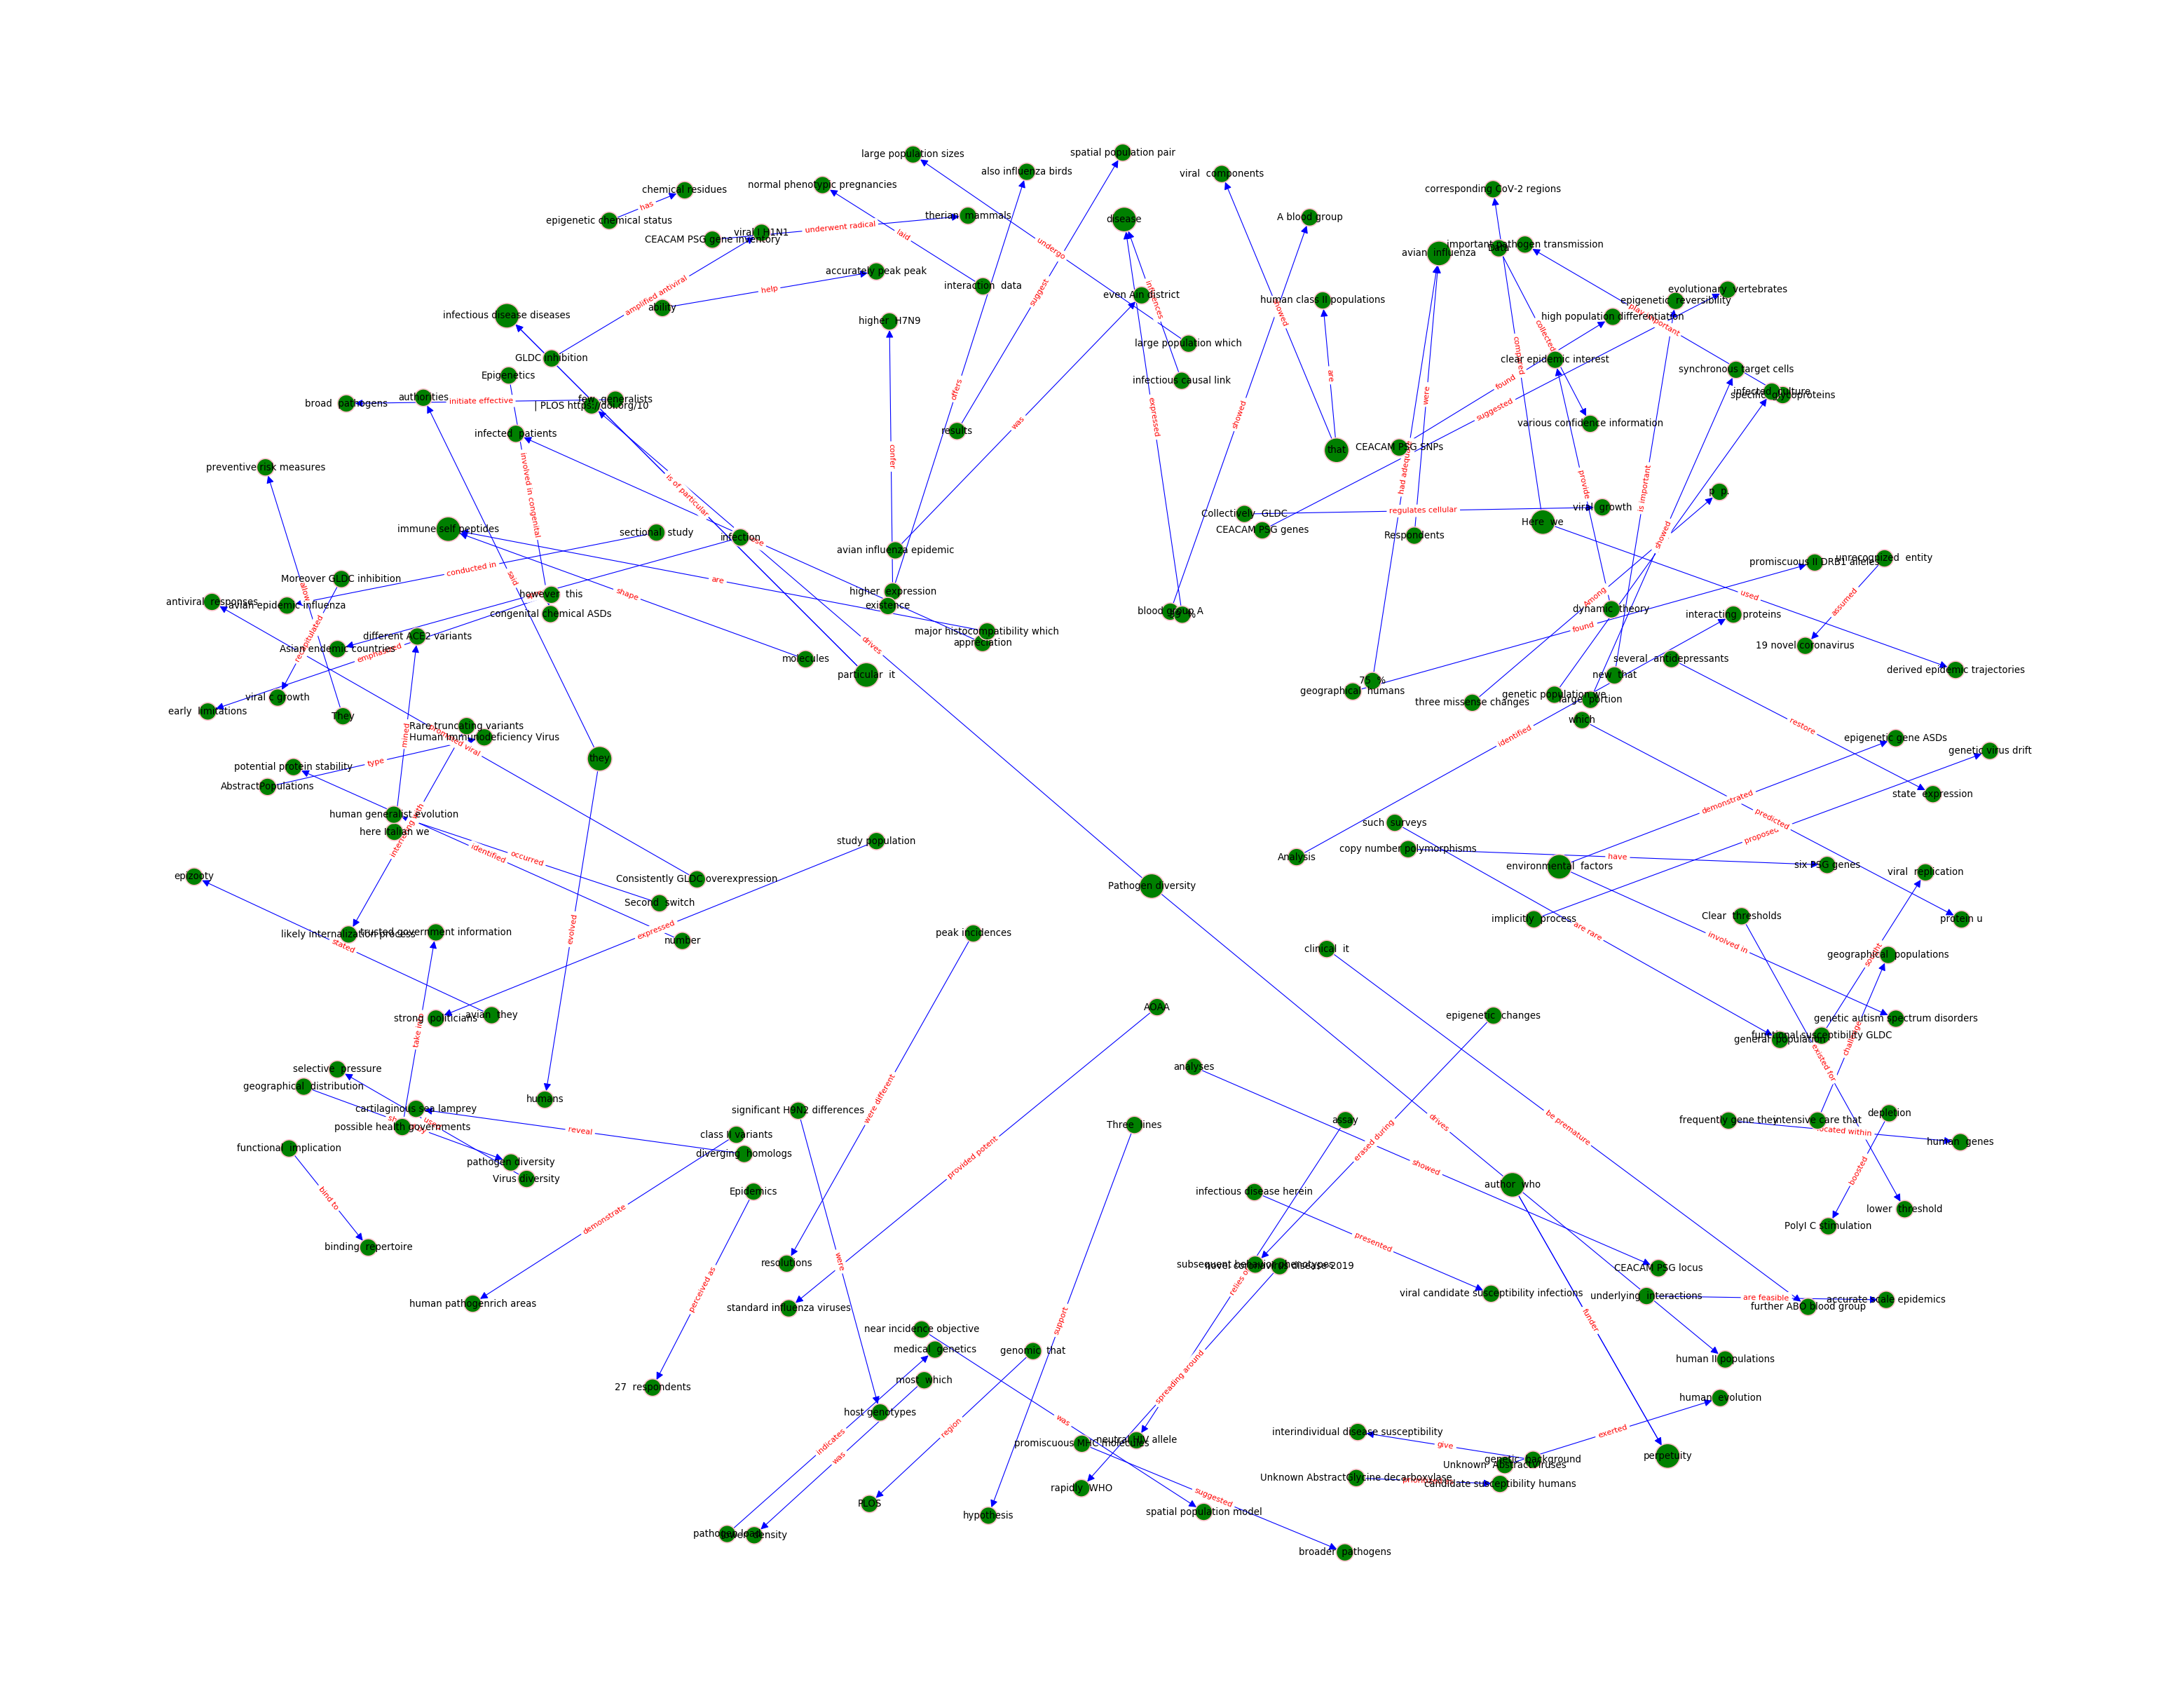

In [86]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')